In [1]:
%cd ../..

/home/eli/AnacondaProjects/epych


In [2]:
# %load_ext autoreload
# %autoreload 2

In [3]:
import collections
import copy
import glob
import functools
import logging
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import quantities as pq

import epych
from epych.statistics import alignment, grand

In [4]:
%matplotlib inline

In [5]:
logging.basicConfig(level=logging.INFO)

In [6]:
CONDITIONS = ["go_gloexp", "go_seqctl", "lo_gloexp", "lonaive", "lo_rndctl", "igo_seqctl"]
PRETRIAL_SECONDS = 0.5
POSTTRIAL_SECONDS = 0.5

In [7]:
# CONTRASTS = [("logo", "lo_gloexp", "go_gloexp"), ("go_contrast", "go_gloexp", "go_seqctl"), ("lo_contrast", "lo_gloexp", "lo_rndctl"), ("ssa", "lo_gloexp", "igo_seqctl"), ("dd", "lo_rndctl", "lonaive")]

In [8]:
CONTRASTS = [("go_contrast", "go_gloexp", "go_seqctl"), ("lo_contrast", "lo_gloexp", "lo_rndctl")]

In [9]:
summaries = {}

In [10]:
area_titles = {
    "VISal": "AL",
    "VISam": "AM",
    "VISl": "LM",
    "VISp": "V1",
    "VISpm": "PM",
    "VISrl": "RL",
}
def stattitle(name, signal):
    if name in area_titles:
        return area_titles[name]
    return name

In [11]:
ADAPTED_ONSET = pq.Quantity(-1.0) * pq.second
ADAPTED_OFFSET = pq.Quantity(-0.5) * pq.second
ODDBALL_ONSET = pq.Quantity(-1.9017372477960602e-14) * pq.second
ODDBALL_OFFSET = pq.Quantity(0.5004545430388676) * pq.second
EVENTS = {
    "Onset": (ODDBALL_ONSET.magnitude, 'lightgreen'),
    "Offset": (ODDBALL_OFFSET.magnitude, 'red'),
}

In [12]:
def initialize_grand_cluster_test(key, signals):
    area = os.path.commonprefix([loc for loc in signals[0].channels.location])
    return epych.statistics.grand.GrandNonparametricClusterTest(aligner.stats[area], alpha=PVALUE, partitions=1000)

def location_prefix_signal_key(probe, signals):
    return alignment.location_prefix(probe, signals[0])

In [13]:
def contrast_path(name):
    return "/mnt/data/DRAFT/000253/" + name + '_4minus3_05'

In [14]:
for (name, _, _) in CONTRASTS:
    summaries[name] = epych.statistic.Summary.unpickle(contrast_path(name), epych.statistics.grand.GrandNonparametricClusterTest)
    for contrast in summaries[name].results().values():
        contrast["signal"]._data = (contrast["signal"]._data * pq.units.volt).rescale('mV')
        contrast["signal"]._dt = contrast["signal"]._dt * pq.second
        contrast["signal"]._timestamps = contrast["signal"]._timestamps * pq.second
    logging.info("Loaded nonparametrically contrasted inner subtractions for %s" % name)

INFO:root:Loaded nonparametrically contrasted inner subtractions for go_contrast
INFO:root:Loaded nonparametrically contrasted inner subtractions for lo_contrast


In [15]:
def csd_with_units(sig):
    result = sig.downsample(4).current_source_density(depth_column="vertical")
    result._data = result.data.rescale('nA / mm**2')
    return result

In [16]:
anatomical_areas = ['VISp', 'VISl', 'VISrl', 'VISal', 'VISpm', 'VISam']

In [17]:
csd_summaries = {}

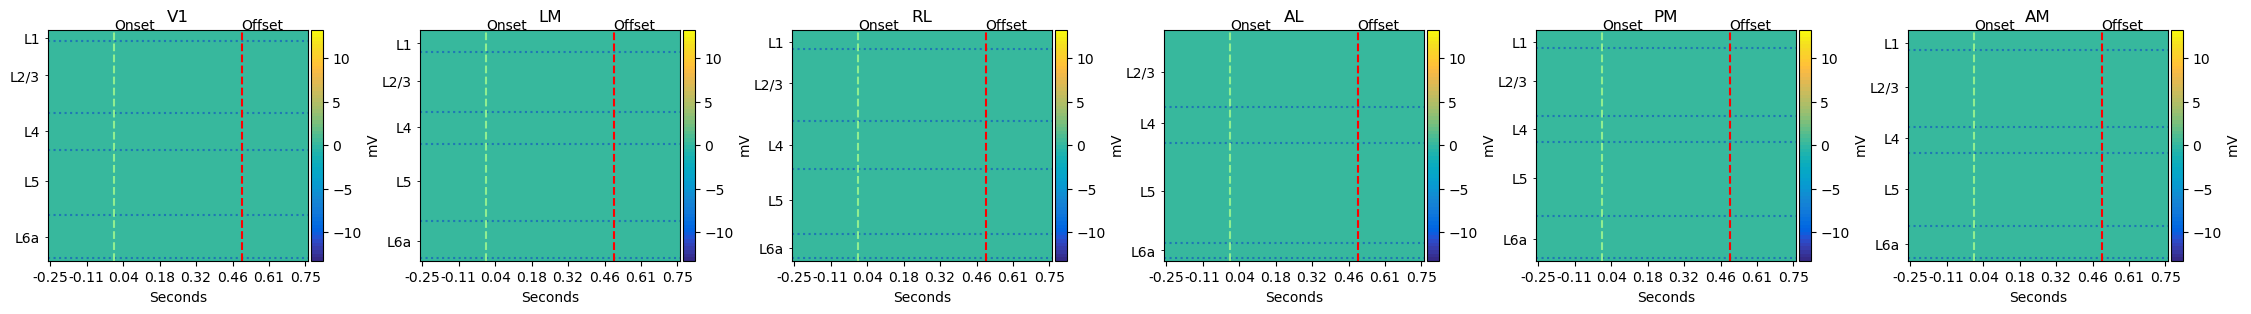

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


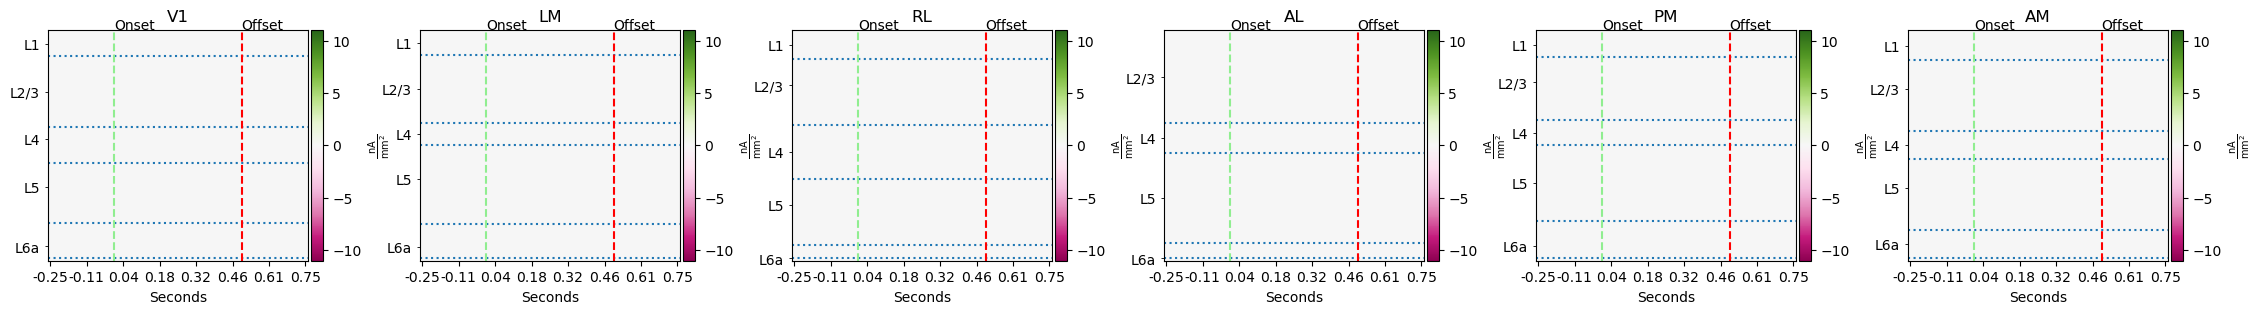

INFO:root:Plotted grand cluster-corrected test contrasts for go_contrast


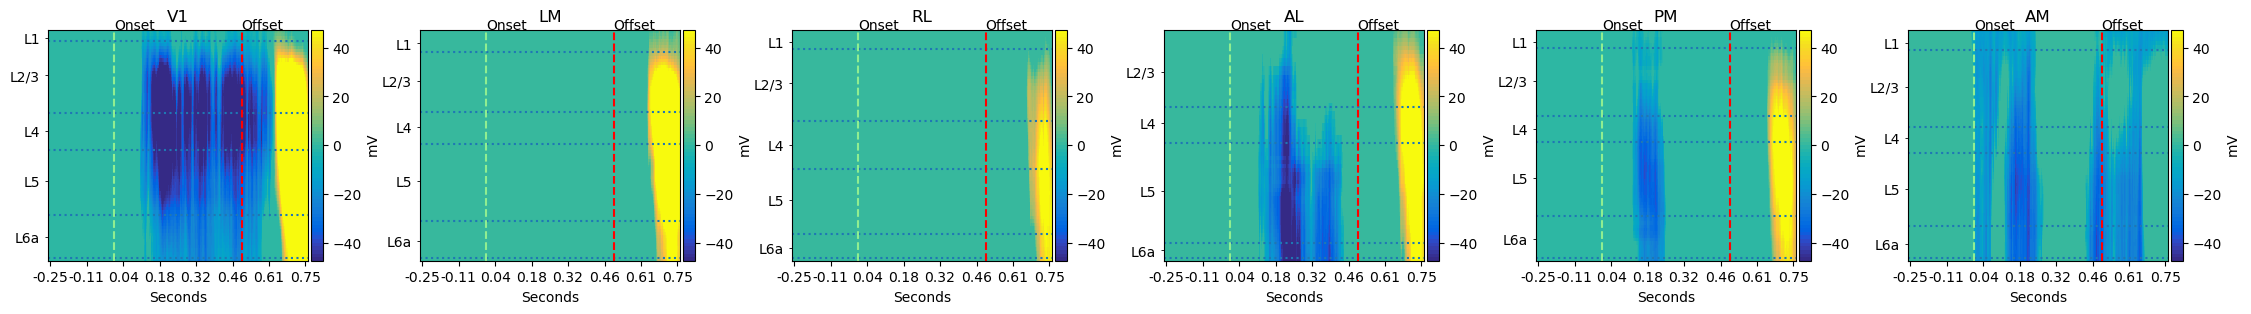

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]
discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


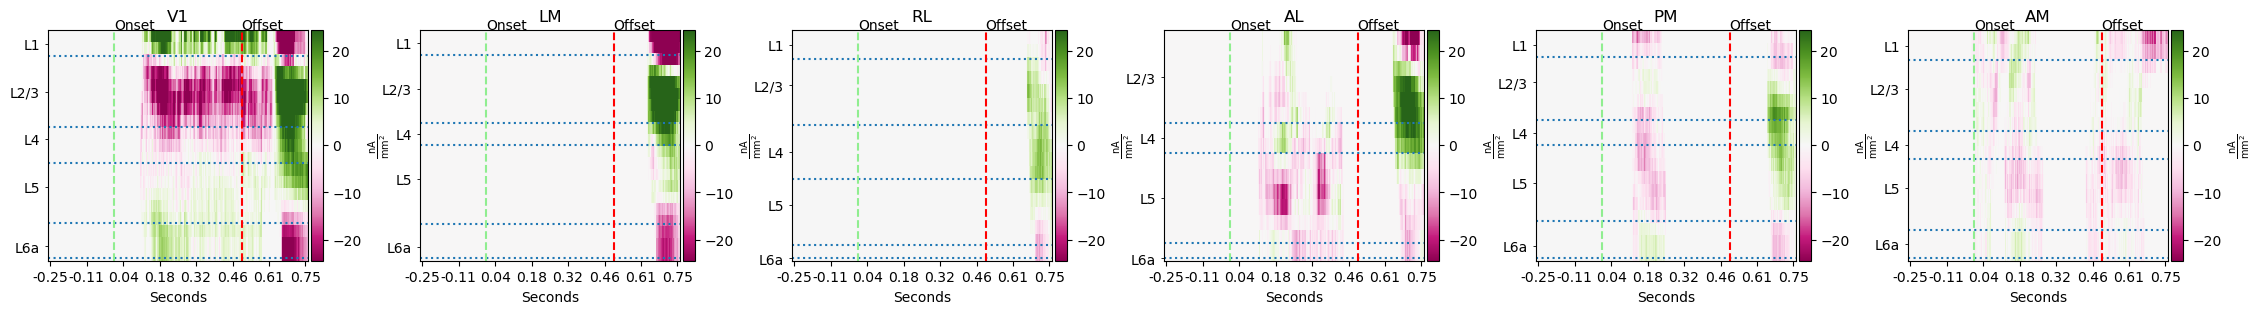

INFO:root:Plotted grand cluster-corrected test contrasts for lo_contrast


In [18]:
for (name, condl, condr) in CONTRASTS:
    ntotal = 0
    variances = 0
    for area in anatomical_areas:
        data = summaries[name].results()[area]['signal'].data
        n = math.prod(data.shape) - 1
        ntotal += n
        variances += data.var().magnitude * n
    std_dev = math.sqrt(variances / ntotal)
    summaries[name].std_dev = std_dev

    summaries[name].plot(figure=contrast_path(name) + "/all_lfps.svg", stats=anatomical_areas, stattitle=stattitle, events=EVENTS,
                         vmin=-2 * std_dev, vmax=2 * std_dev, cbar=True)

    csd_summaries[name] = copy.deepcopy(summaries[name])
    ntotal = 0
    variances = 0
    for area in anatomical_areas:
        csd_summaries[name].results()[area]['mask'] = csd_summaries[name].results()[area]['mask'][::4, :]
        csd_summaries[name].results()[area]['signal'] = csd_with_units(csd_summaries[name].results()[area]['signal'])
        data = csd_summaries[name].results()[area]['signal'].data
        n = math.prod(data.shape) - 1
        ntotal += n
        variances += data.var().magnitude * n
    std_dev = math.sqrt(variances / ntotal)
    csd_summaries[name].std_dev = std_dev
    
    csd_summaries[name].plot(cmap='PiYG', stats=anatomical_areas, figure=contrast_path(name) + "/all_csds.svg",
                             stattitle=stattitle, events=EVENTS, vmin=-2 * std_dev, vmax=2 * std_dev, cbar=True)
    
    logging.info("Plotted grand cluster-corrected test contrasts for %s" % name)

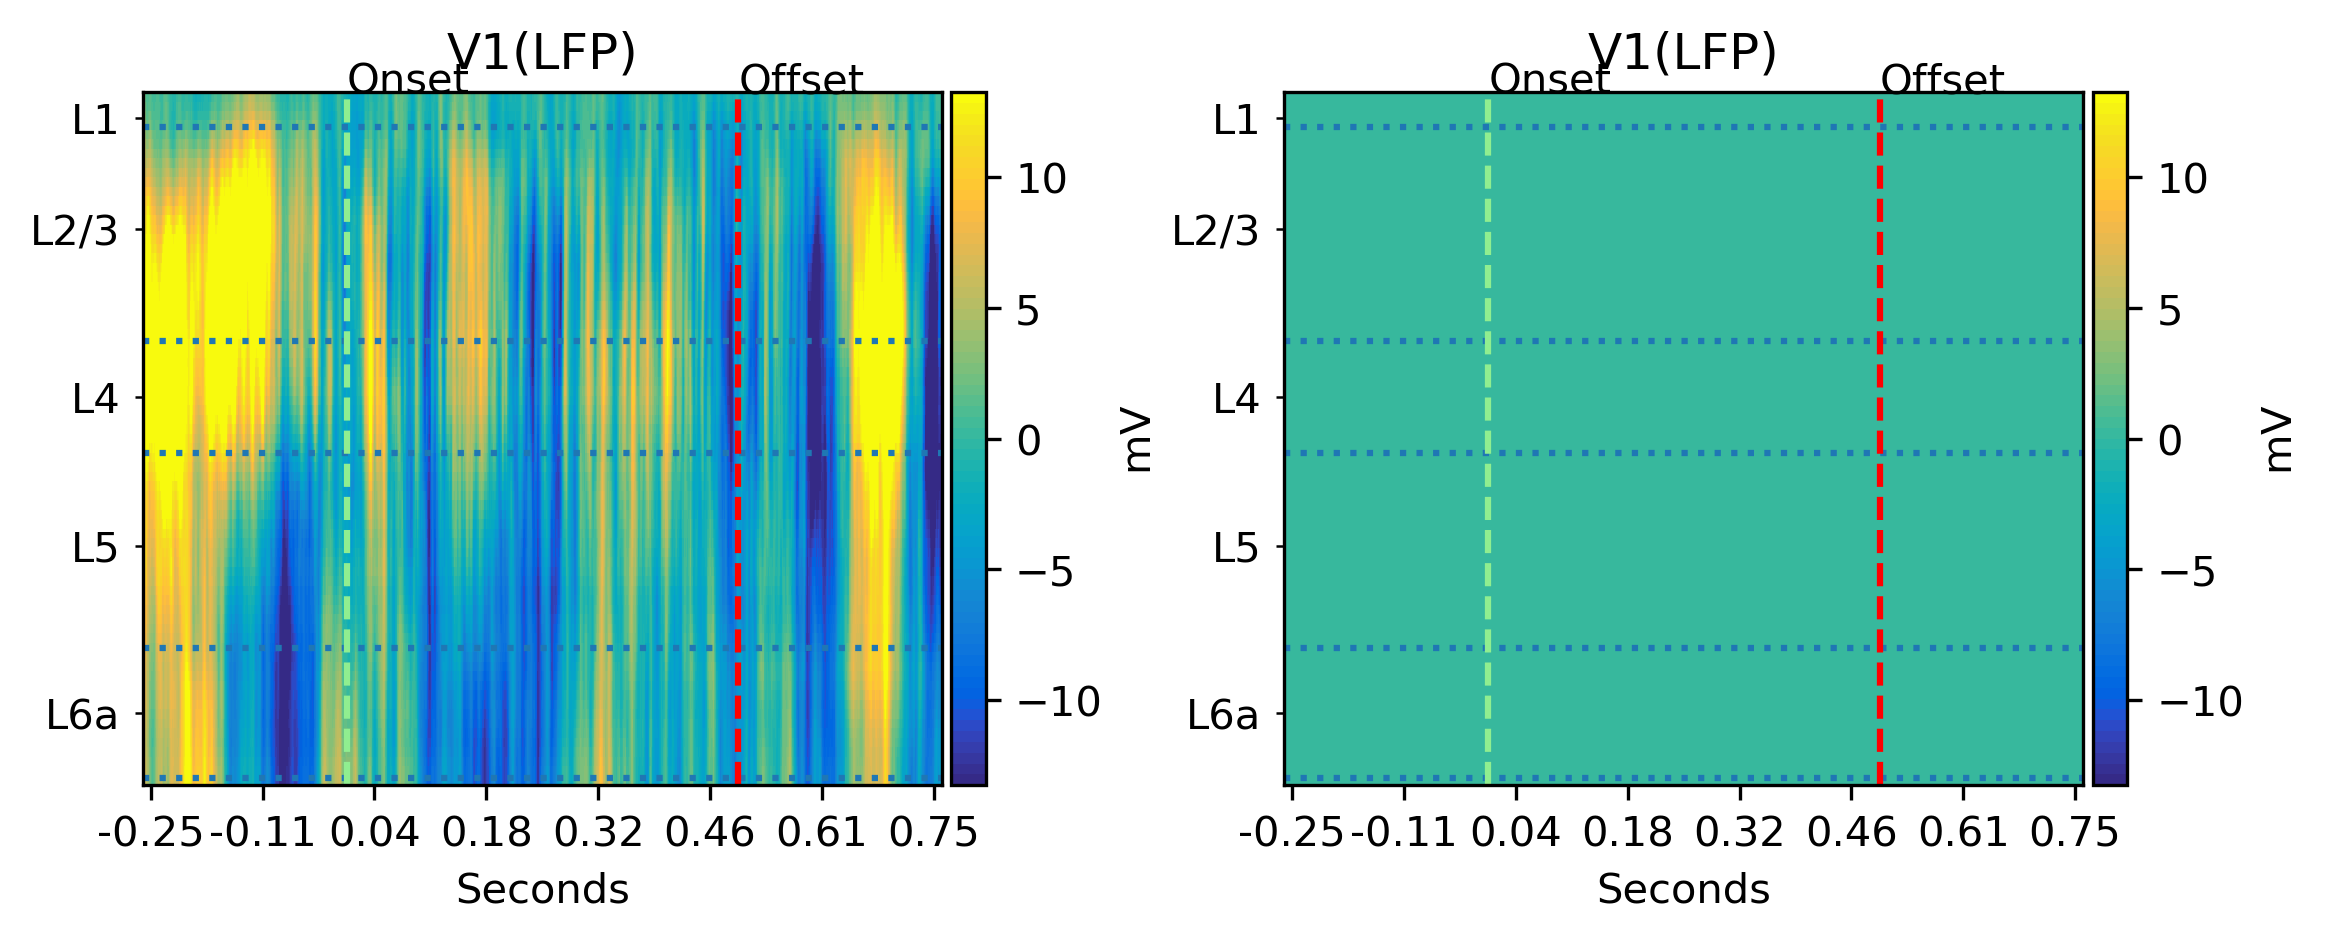

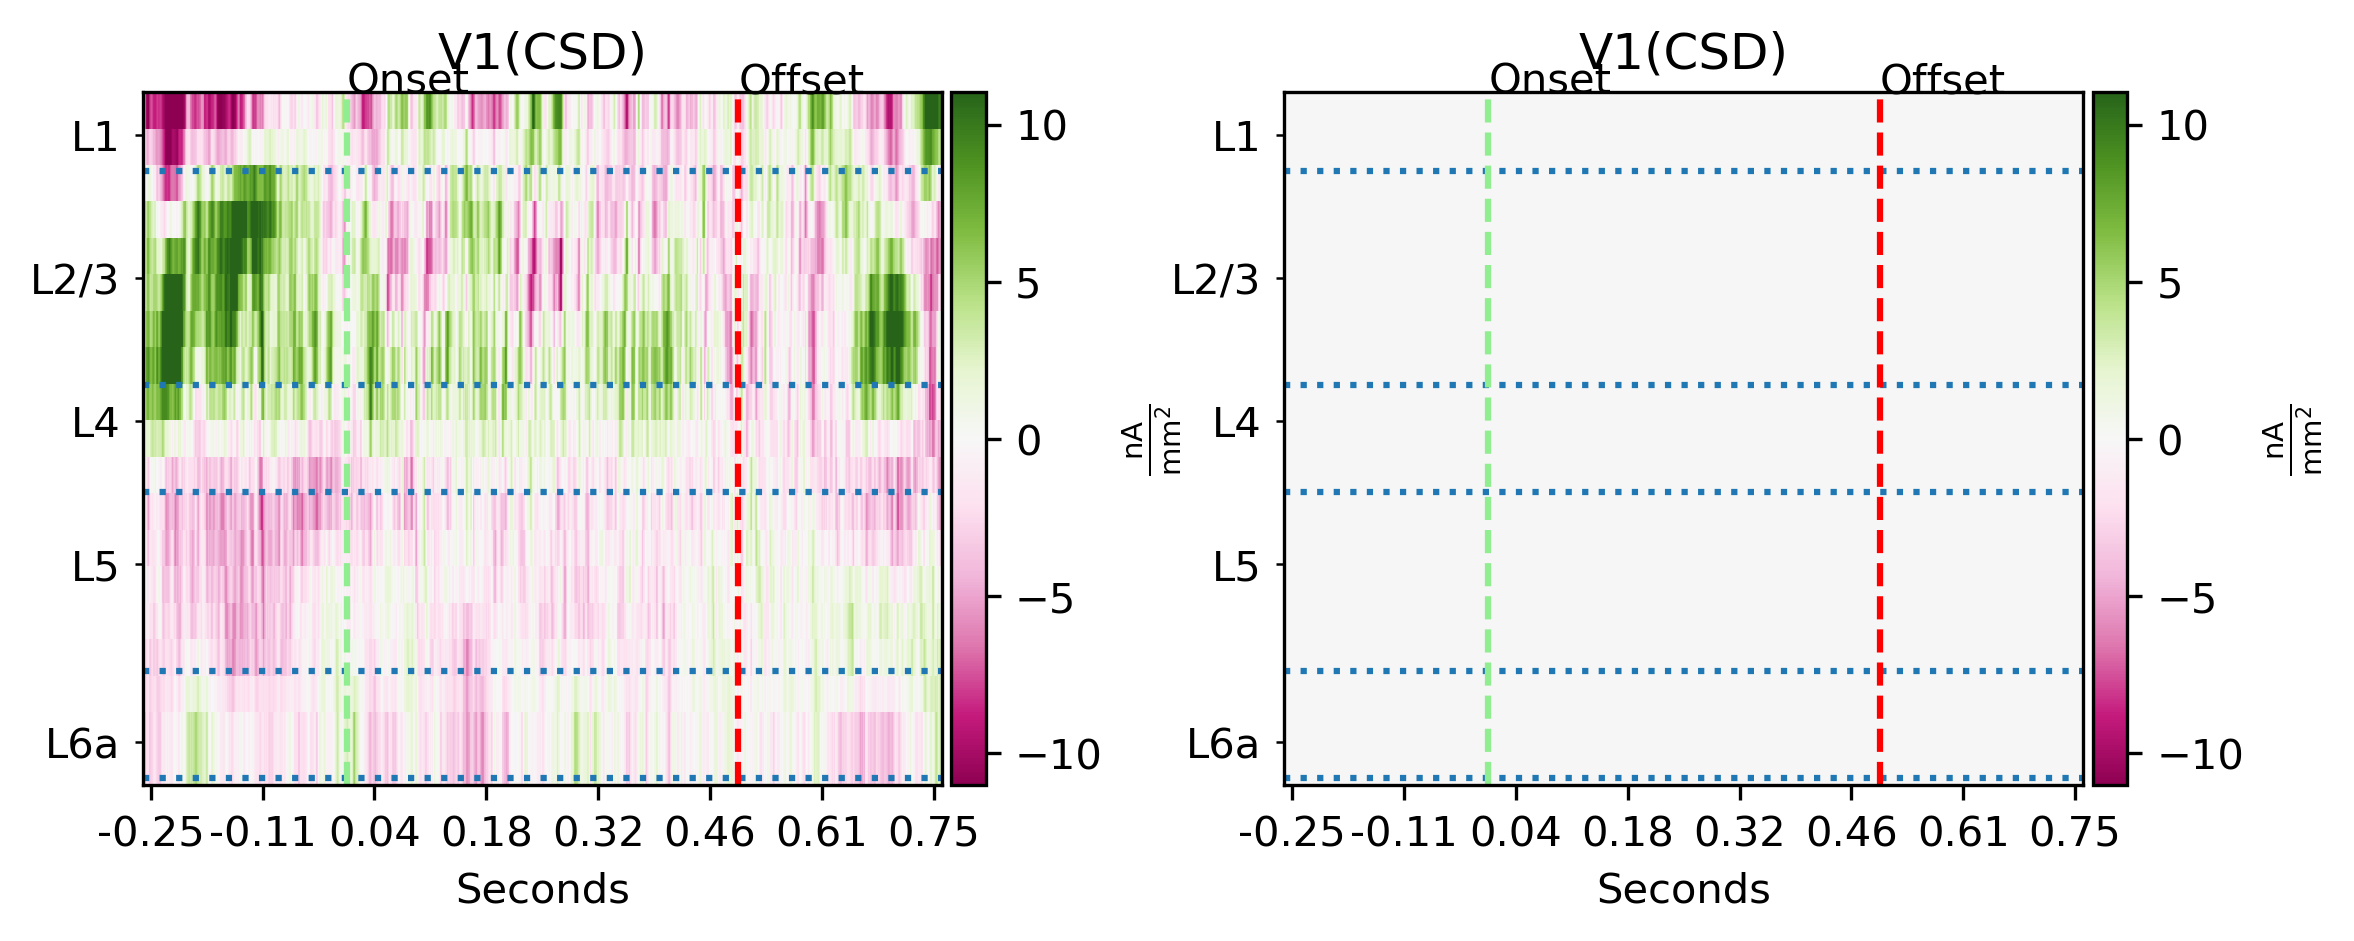

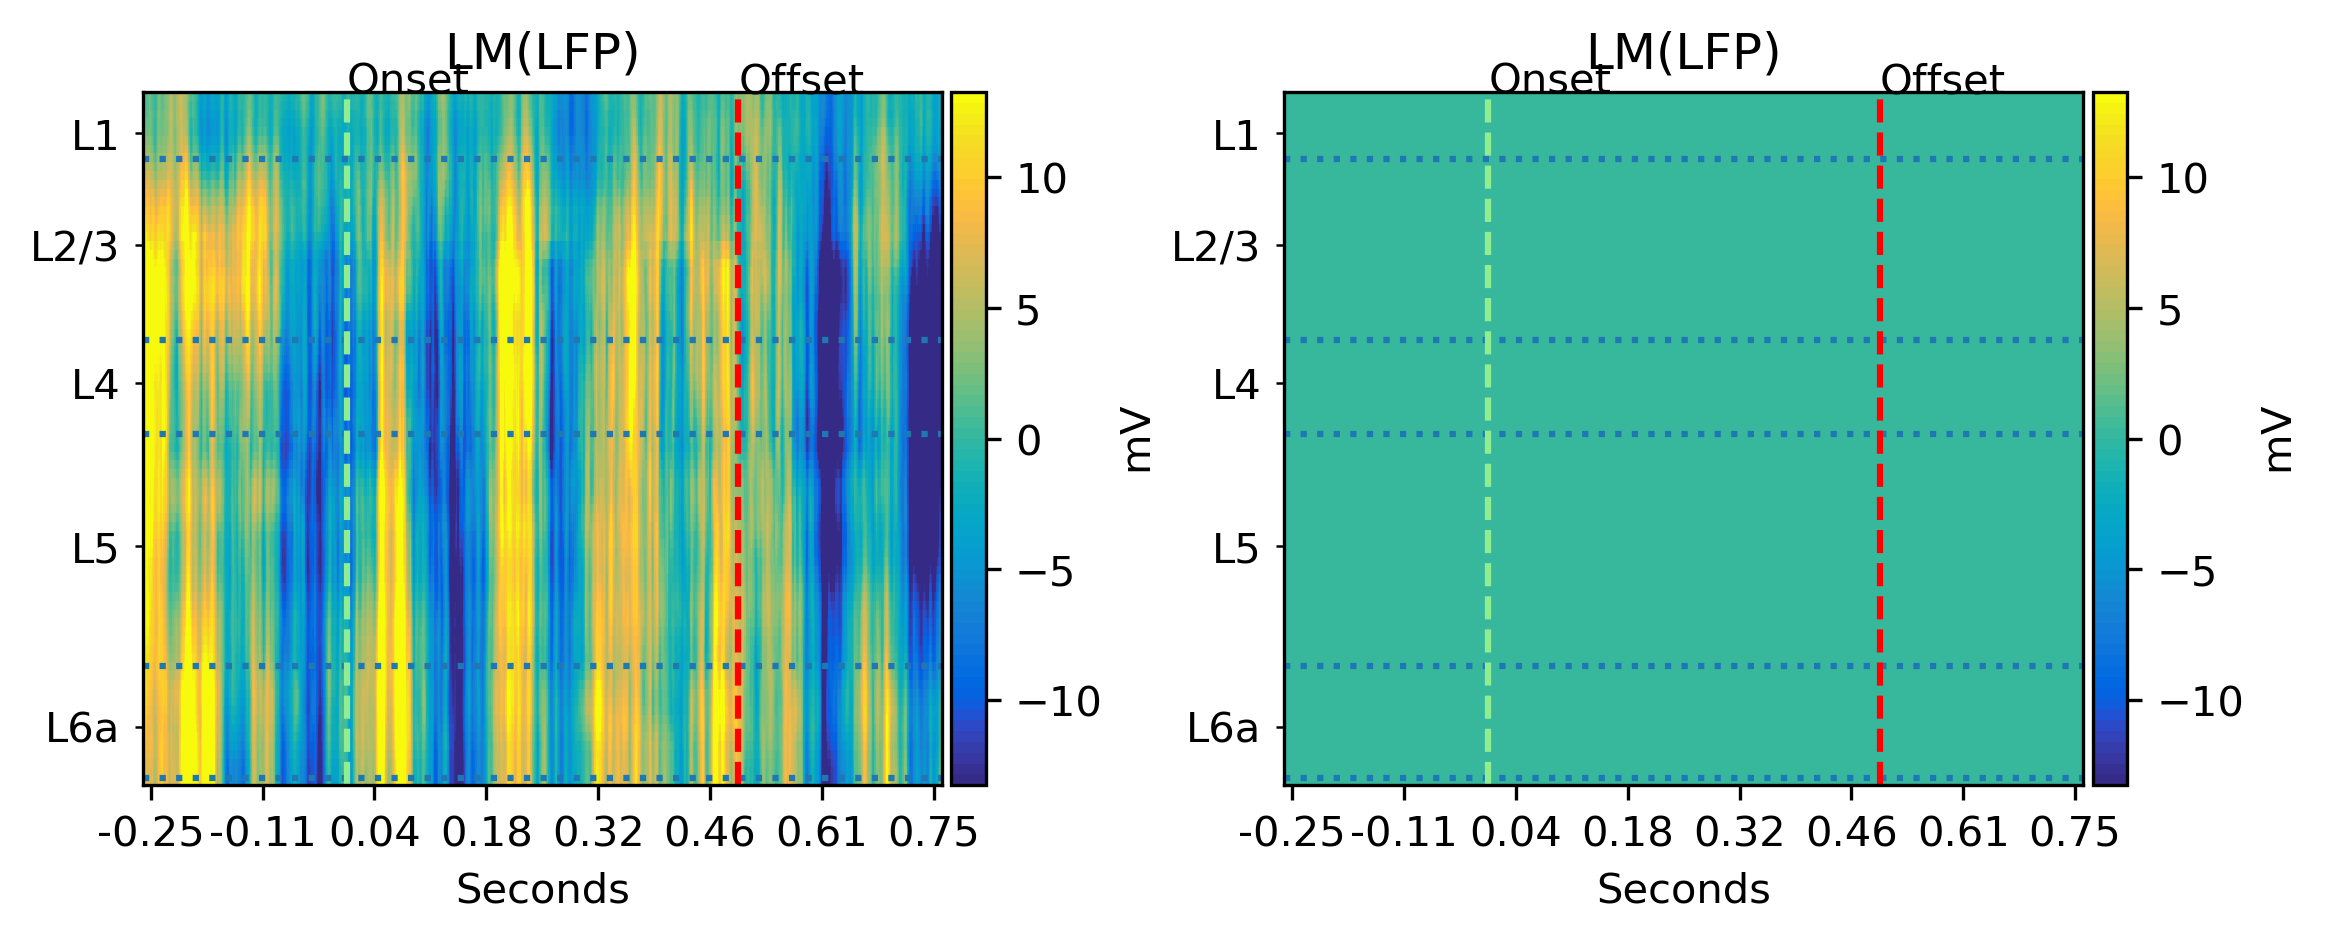

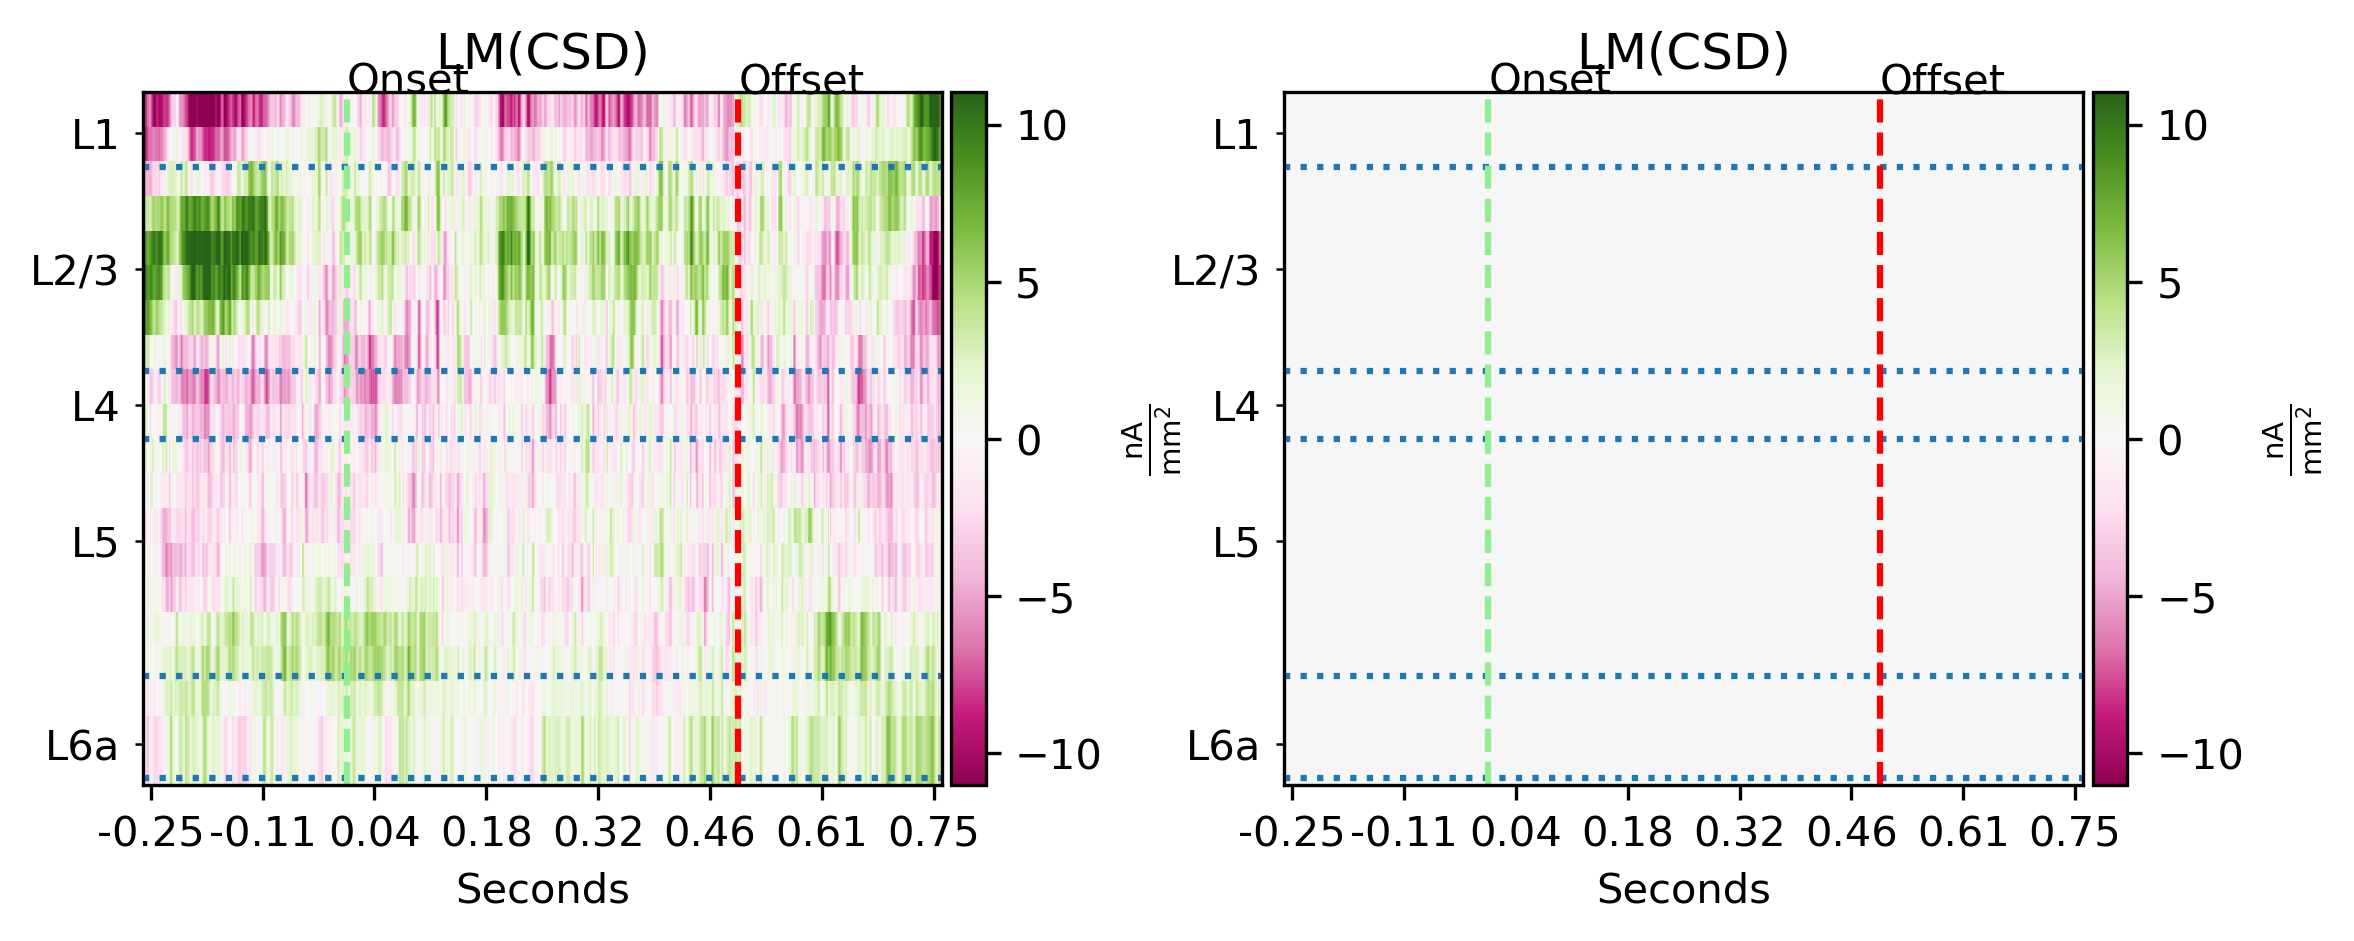

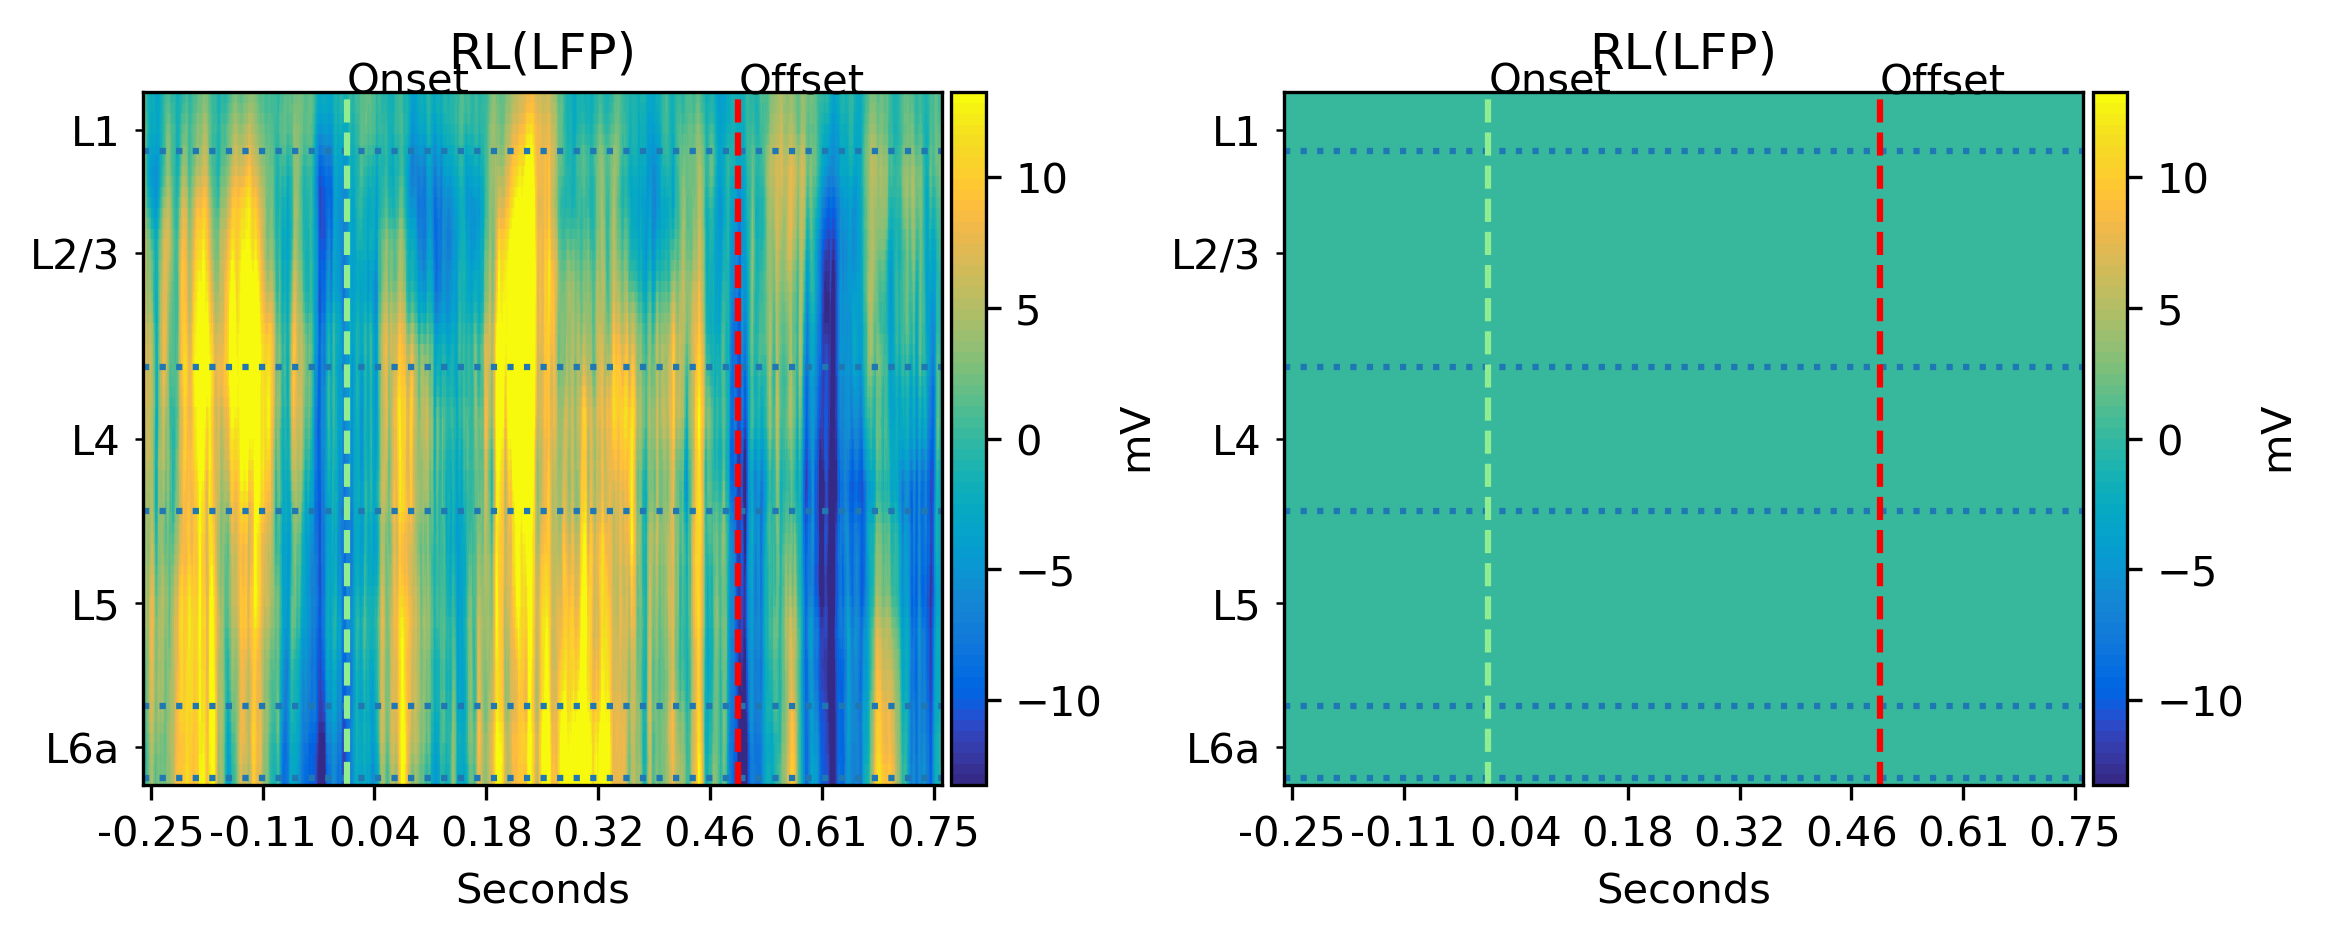

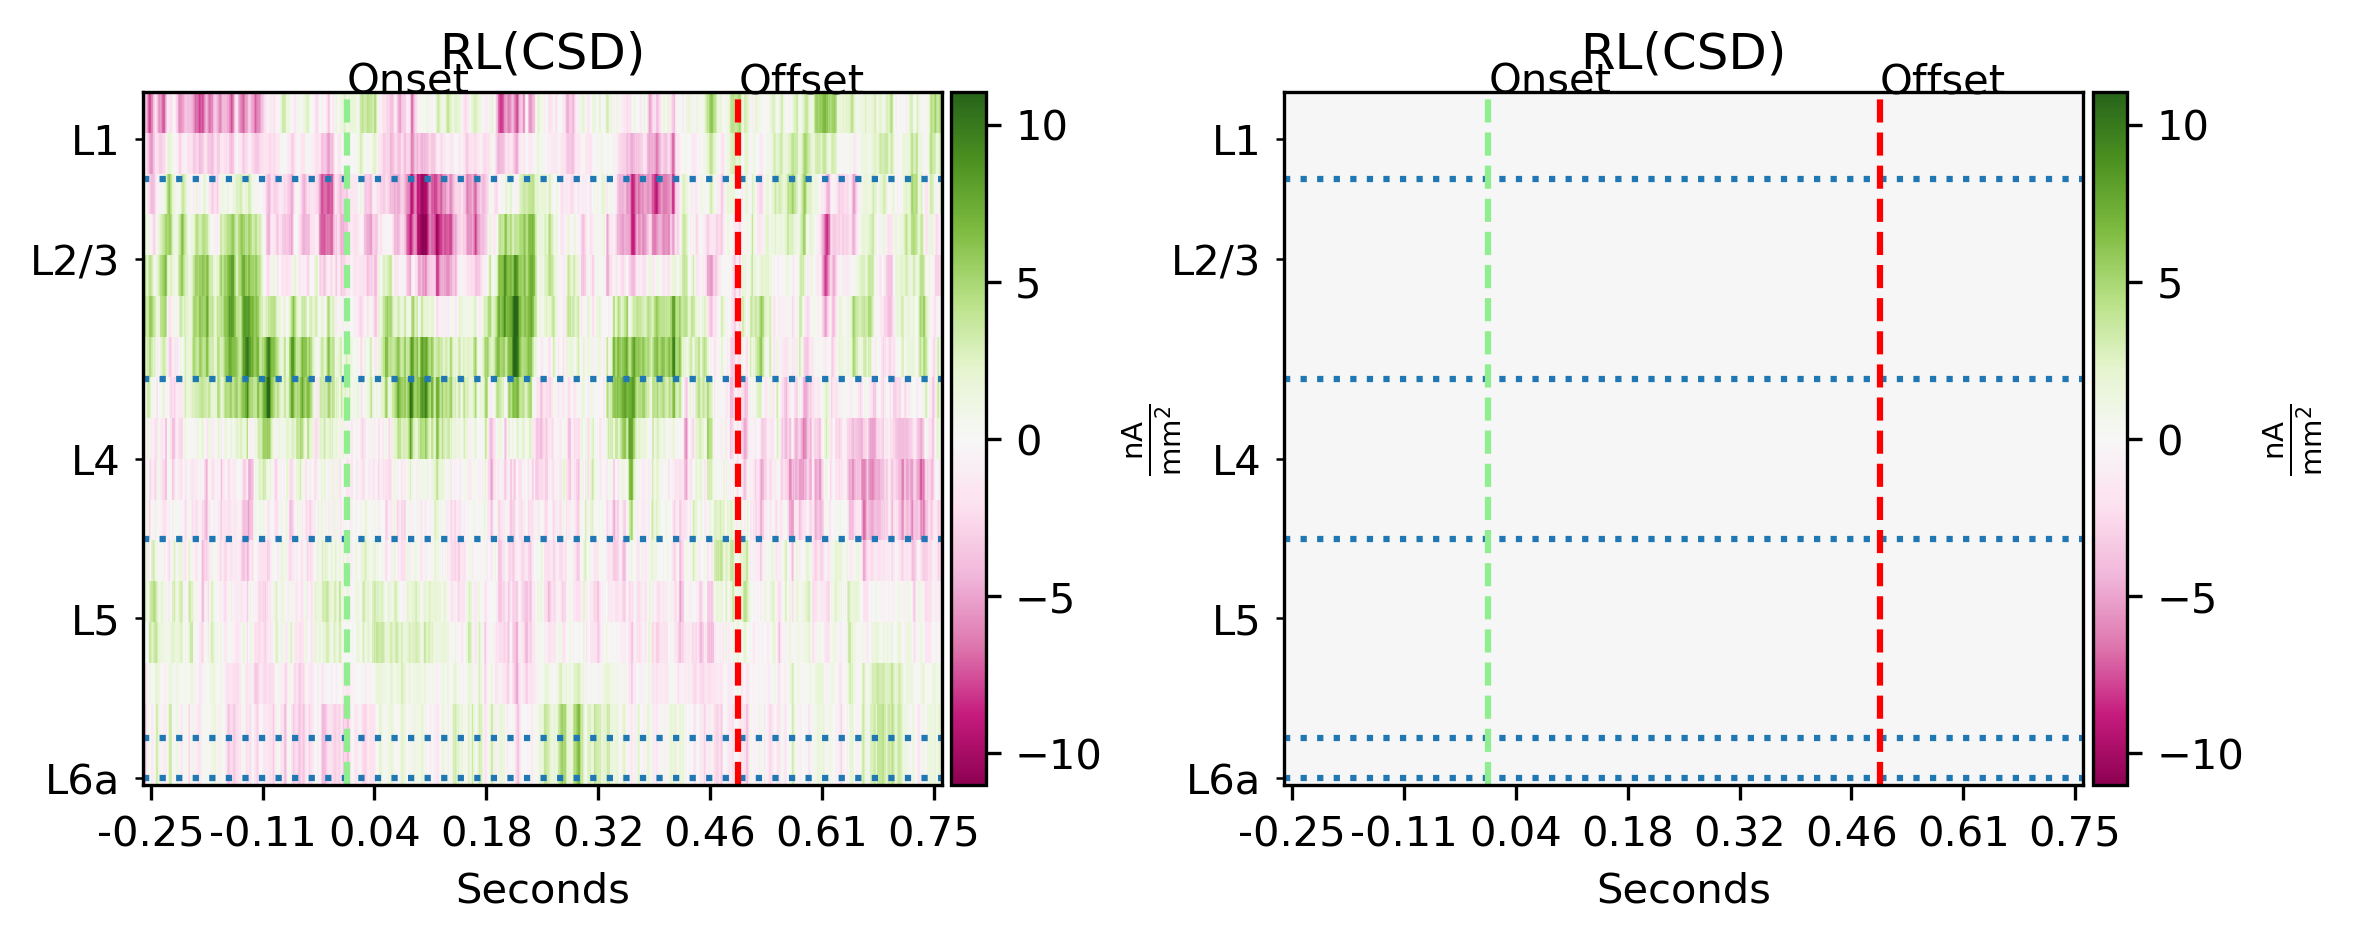

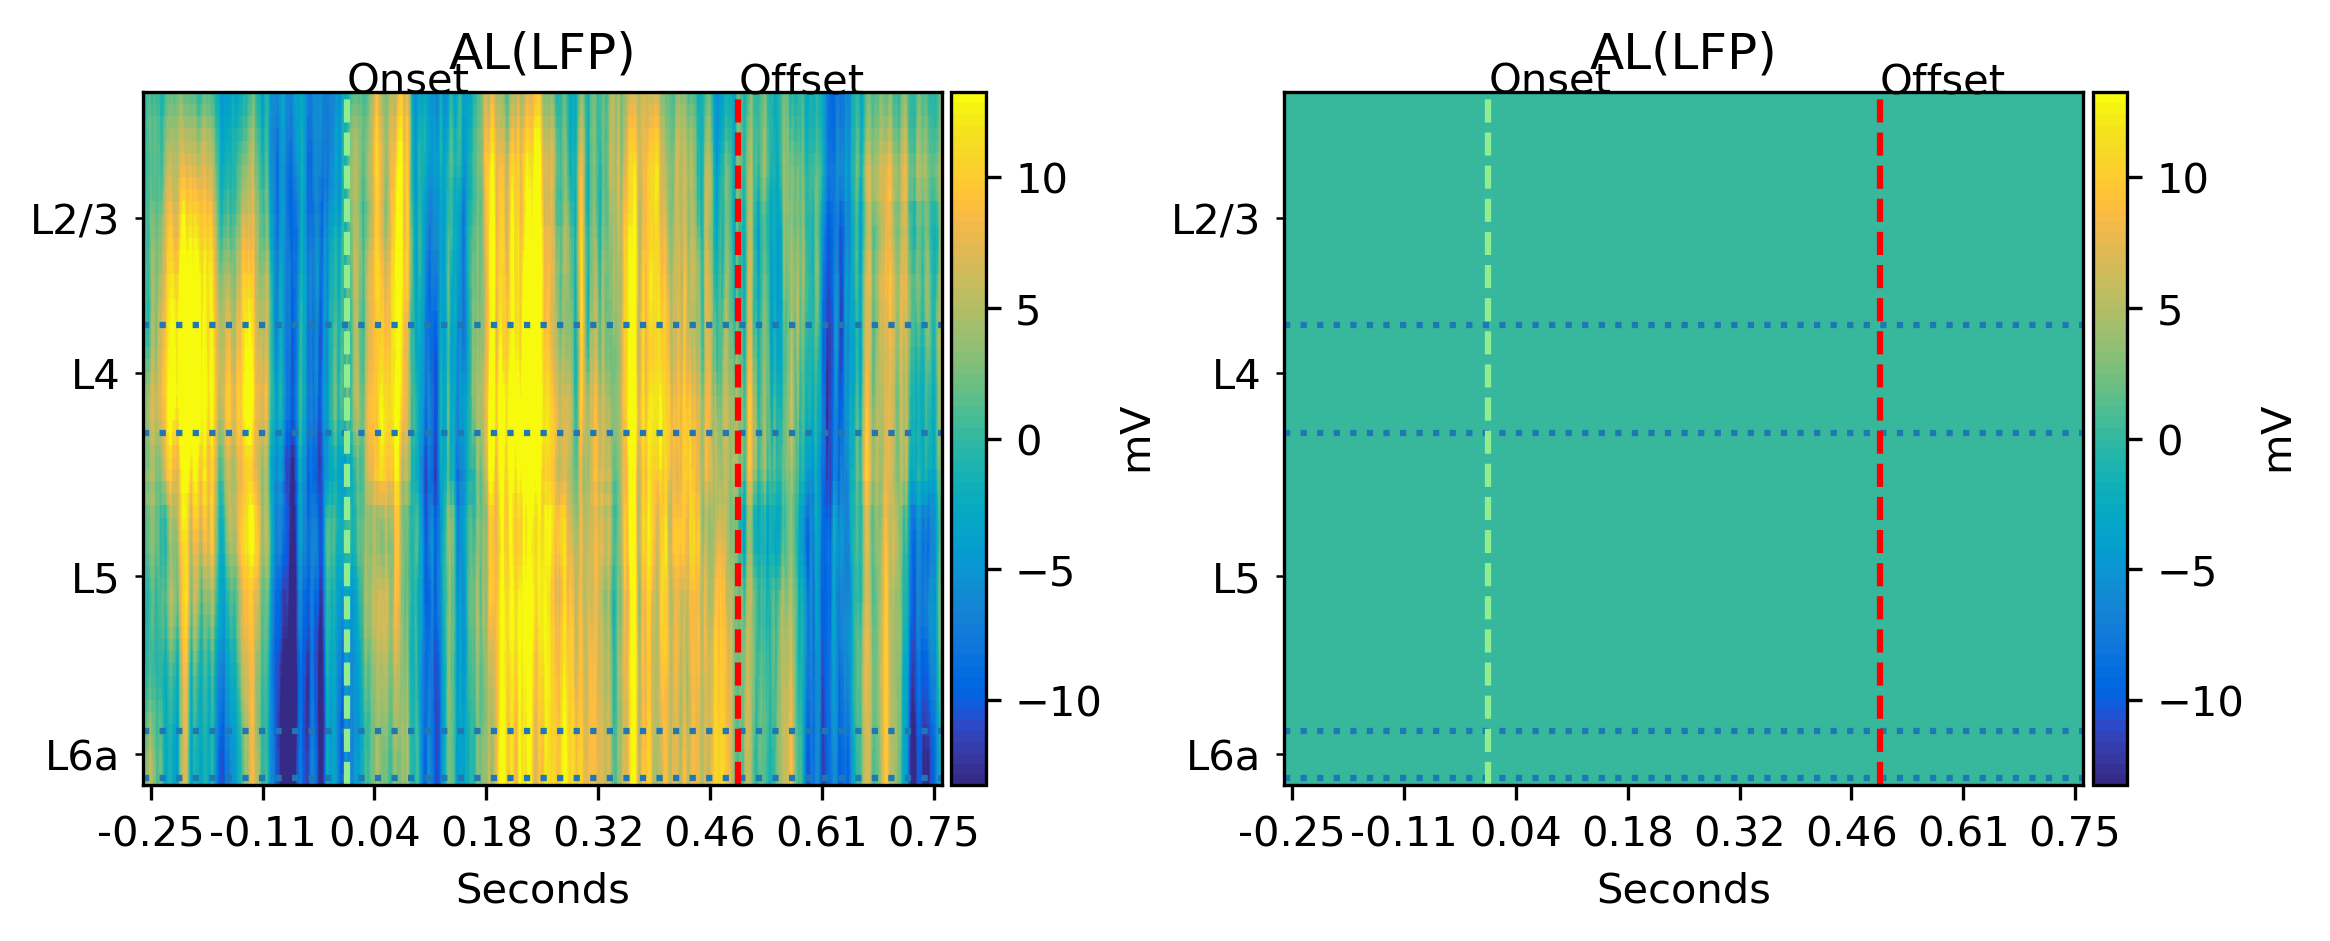

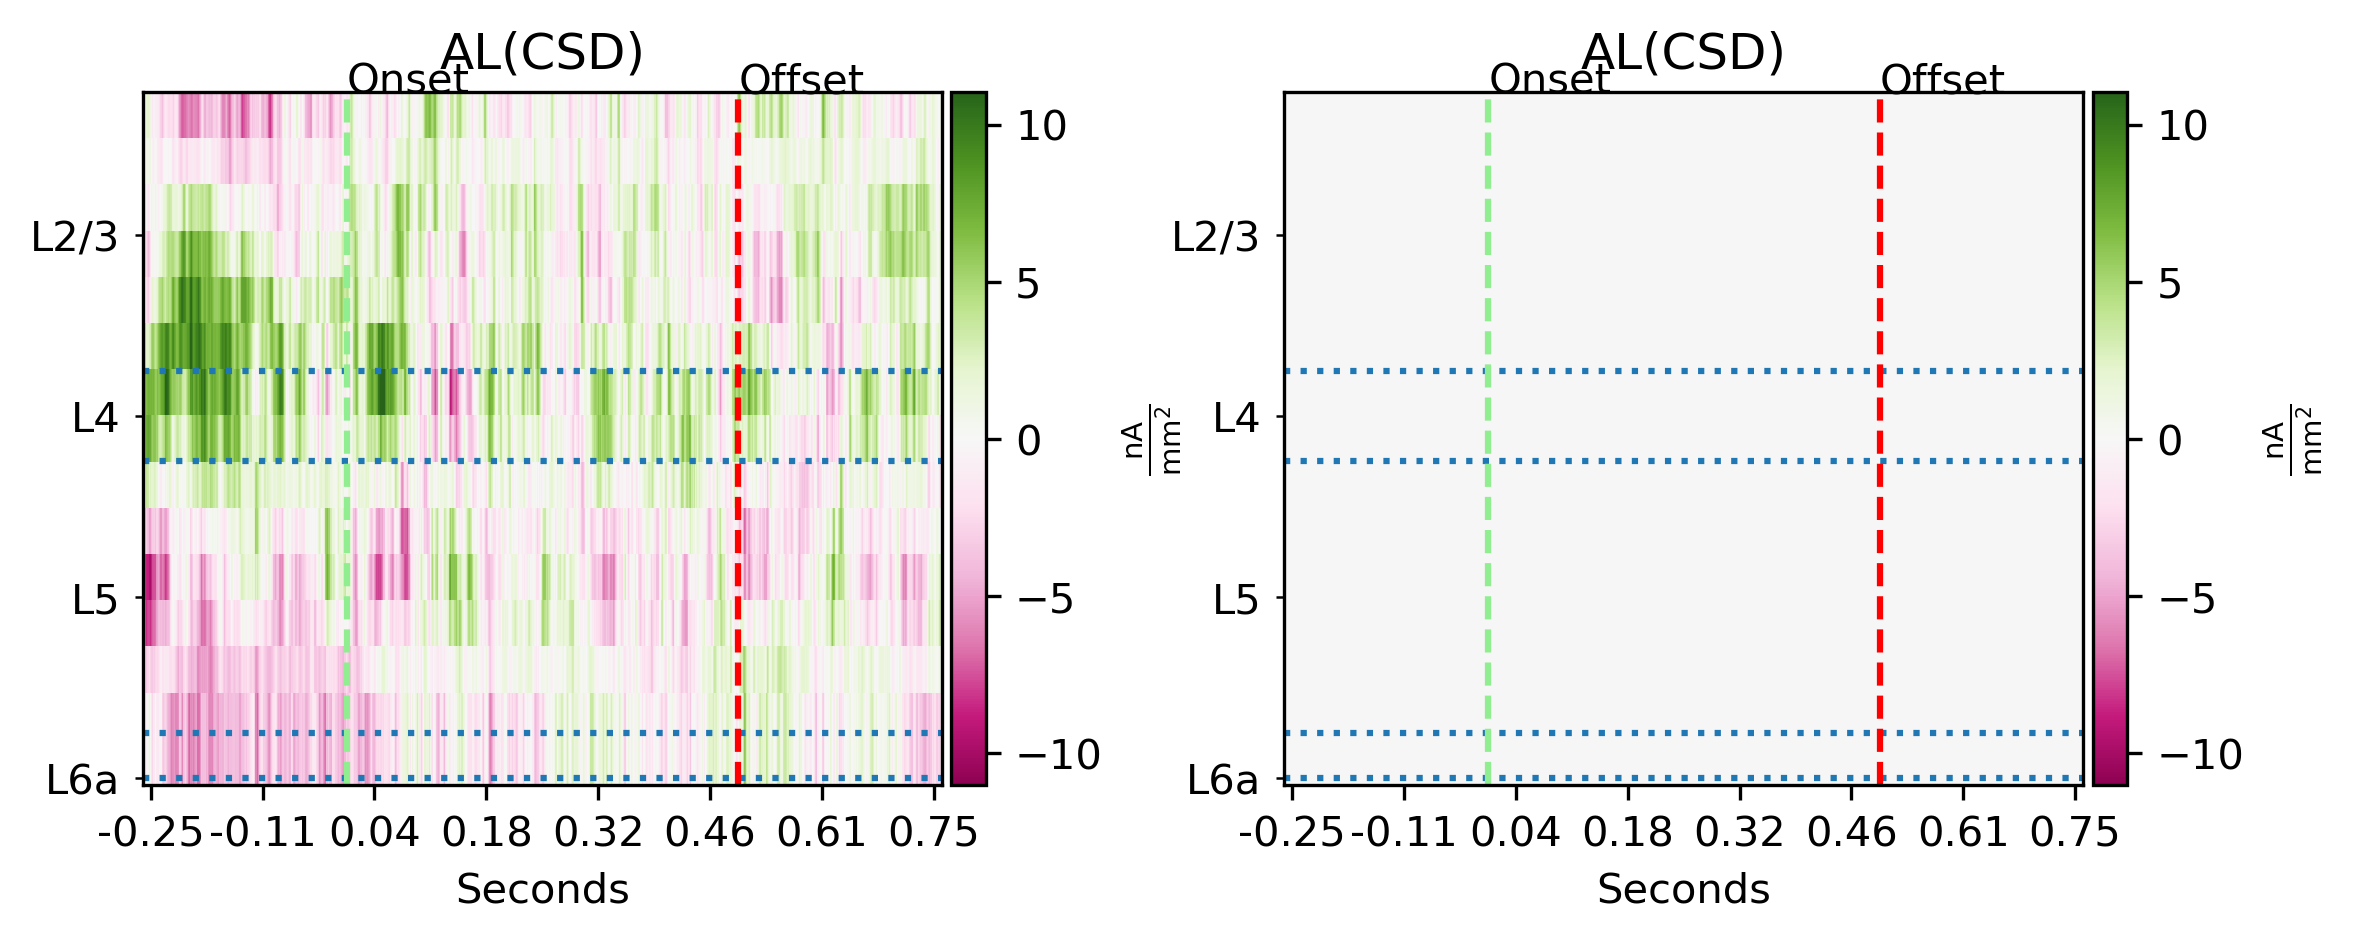

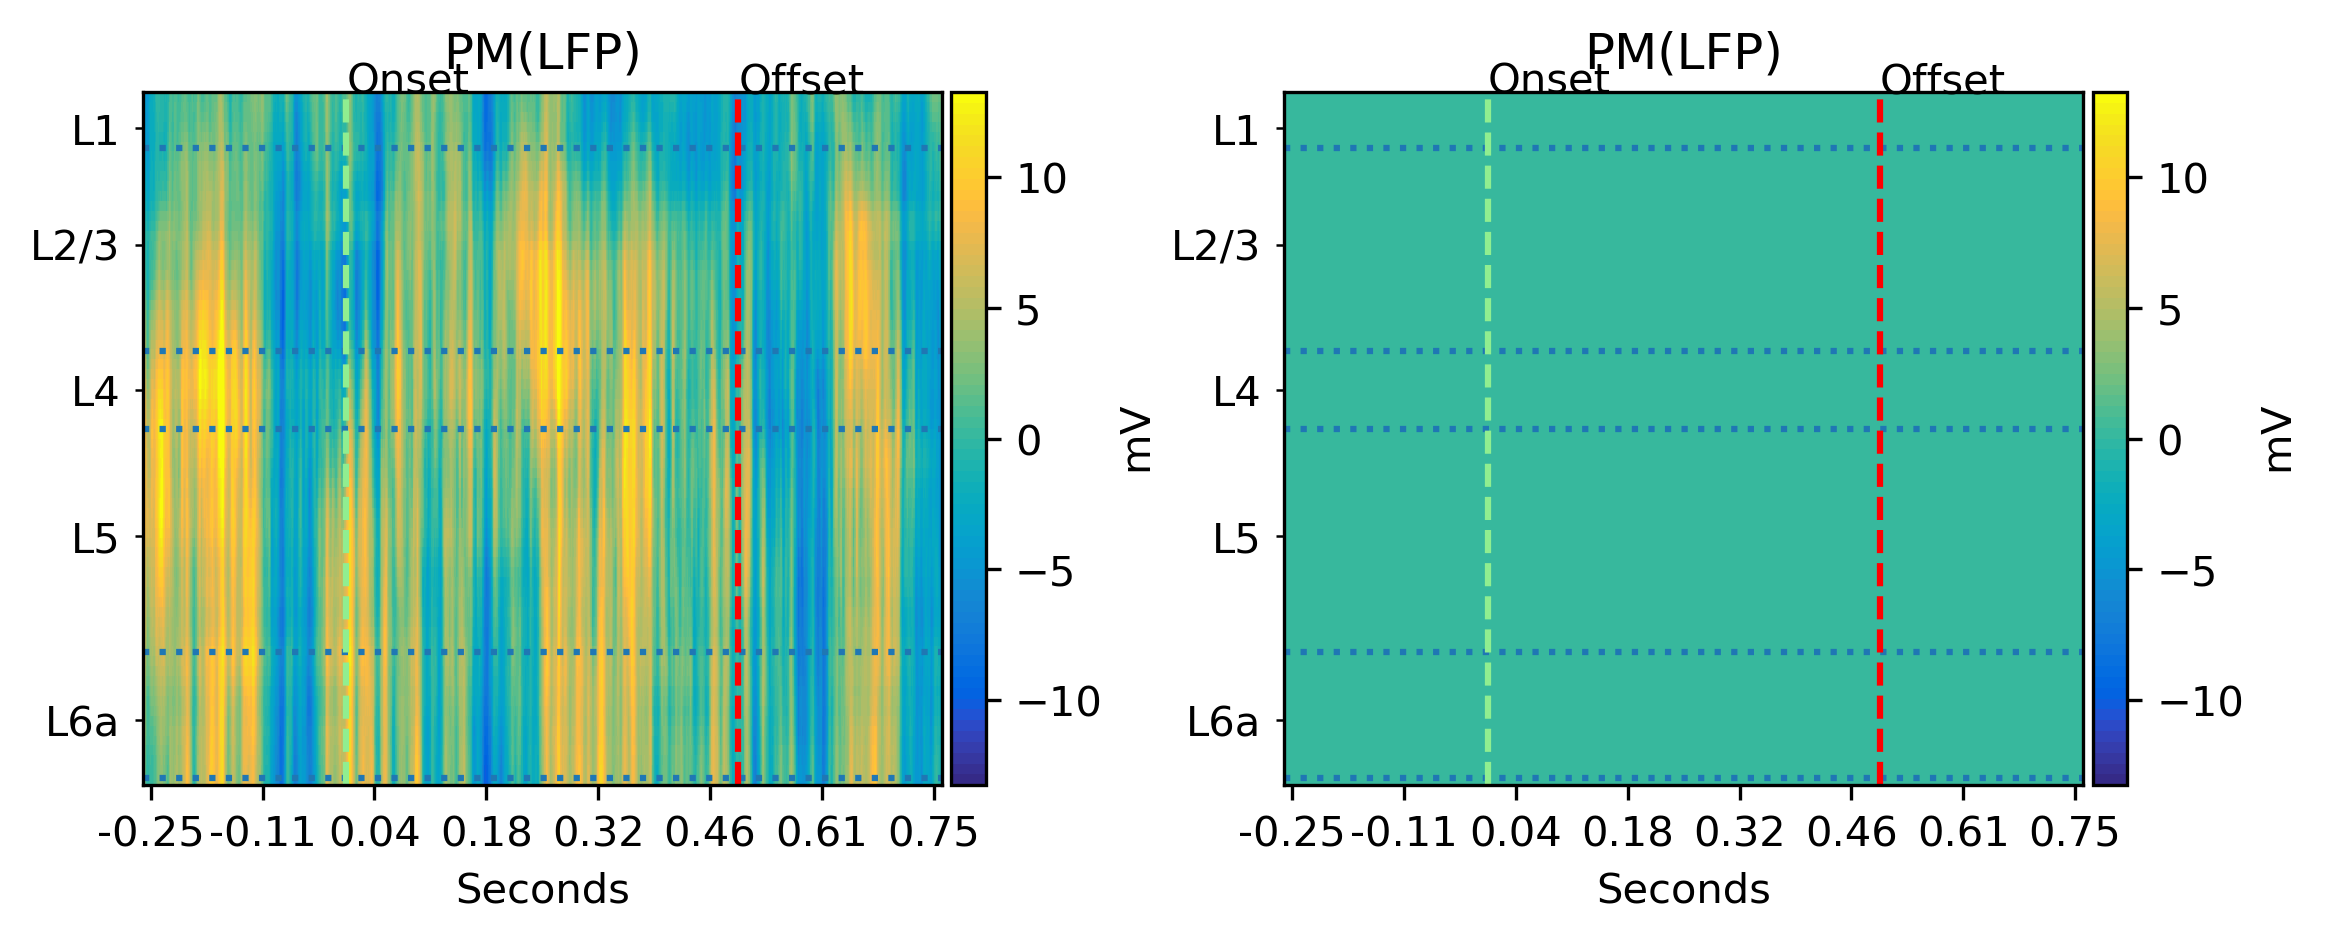

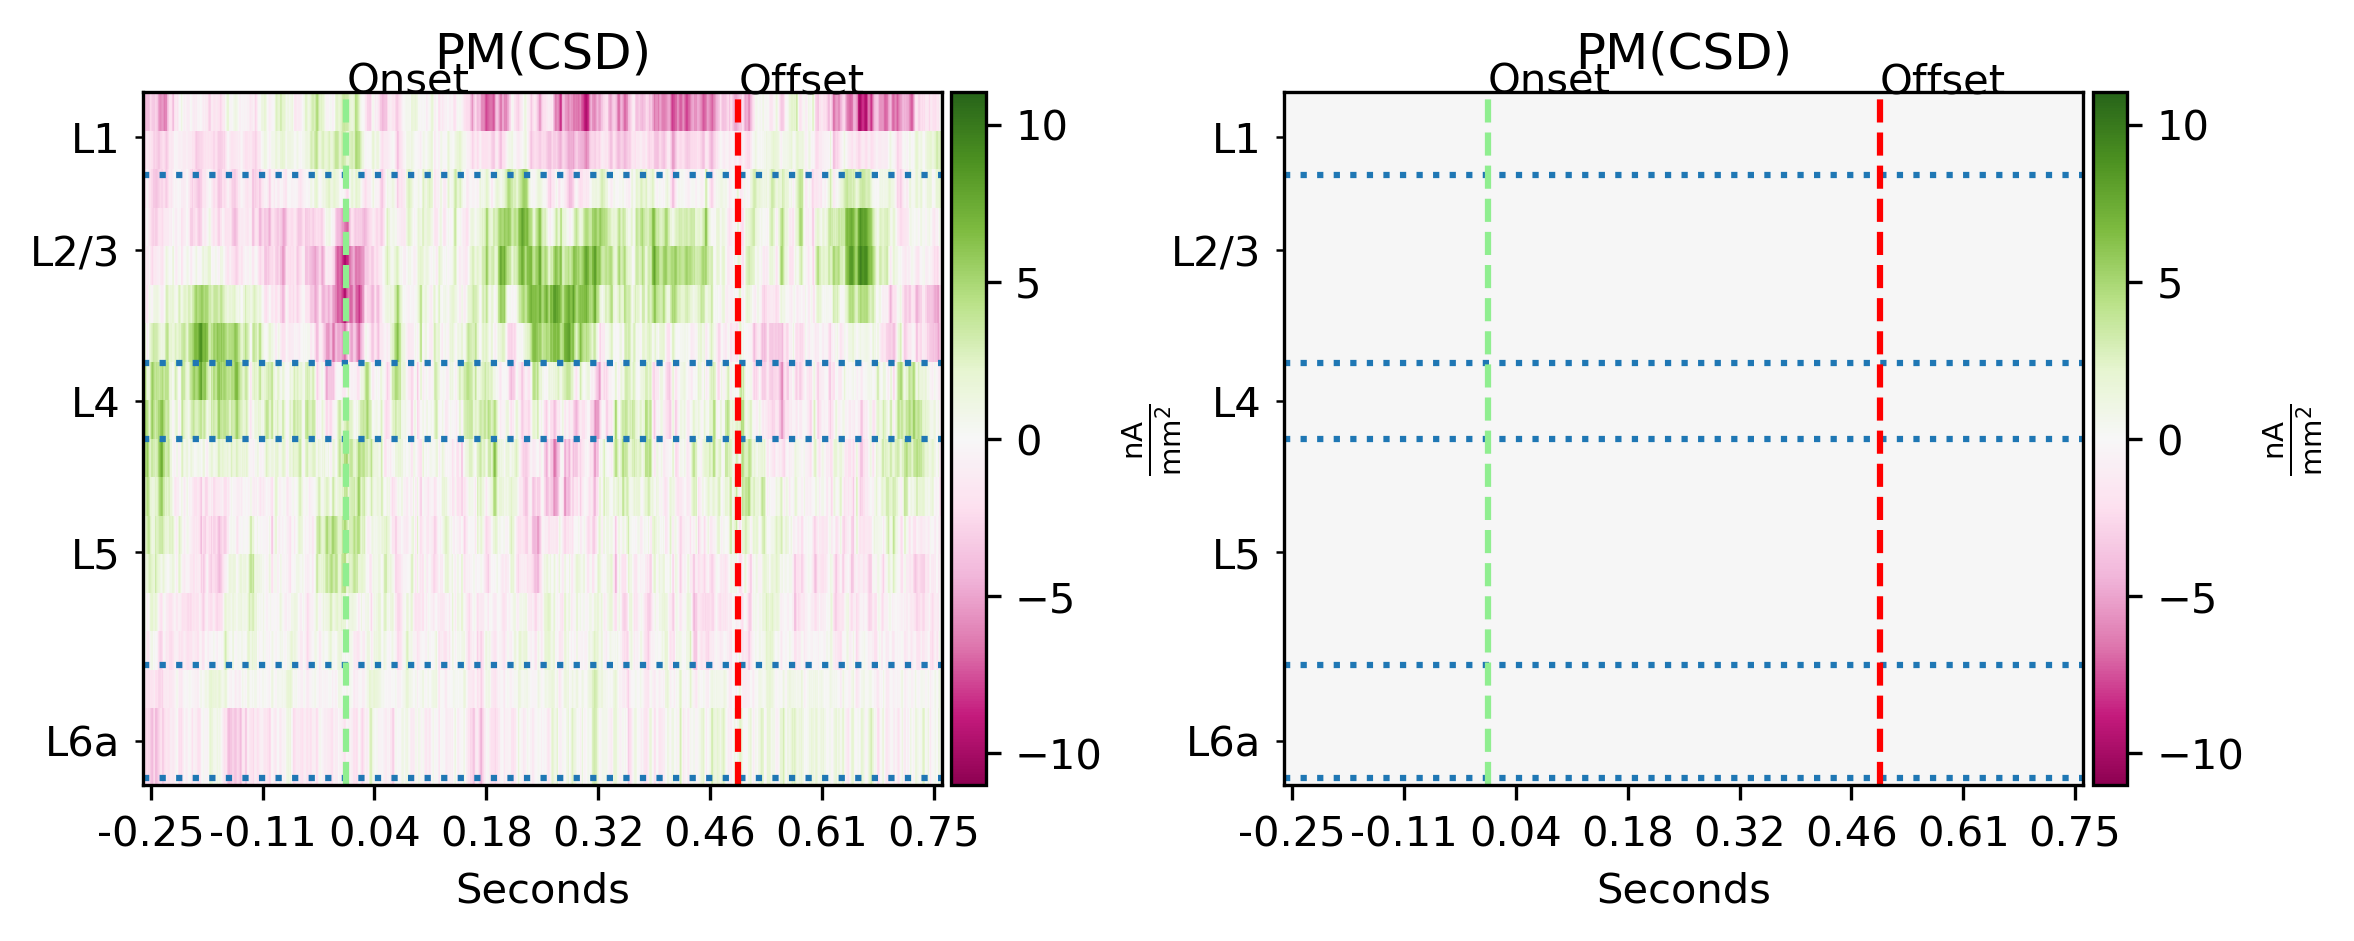

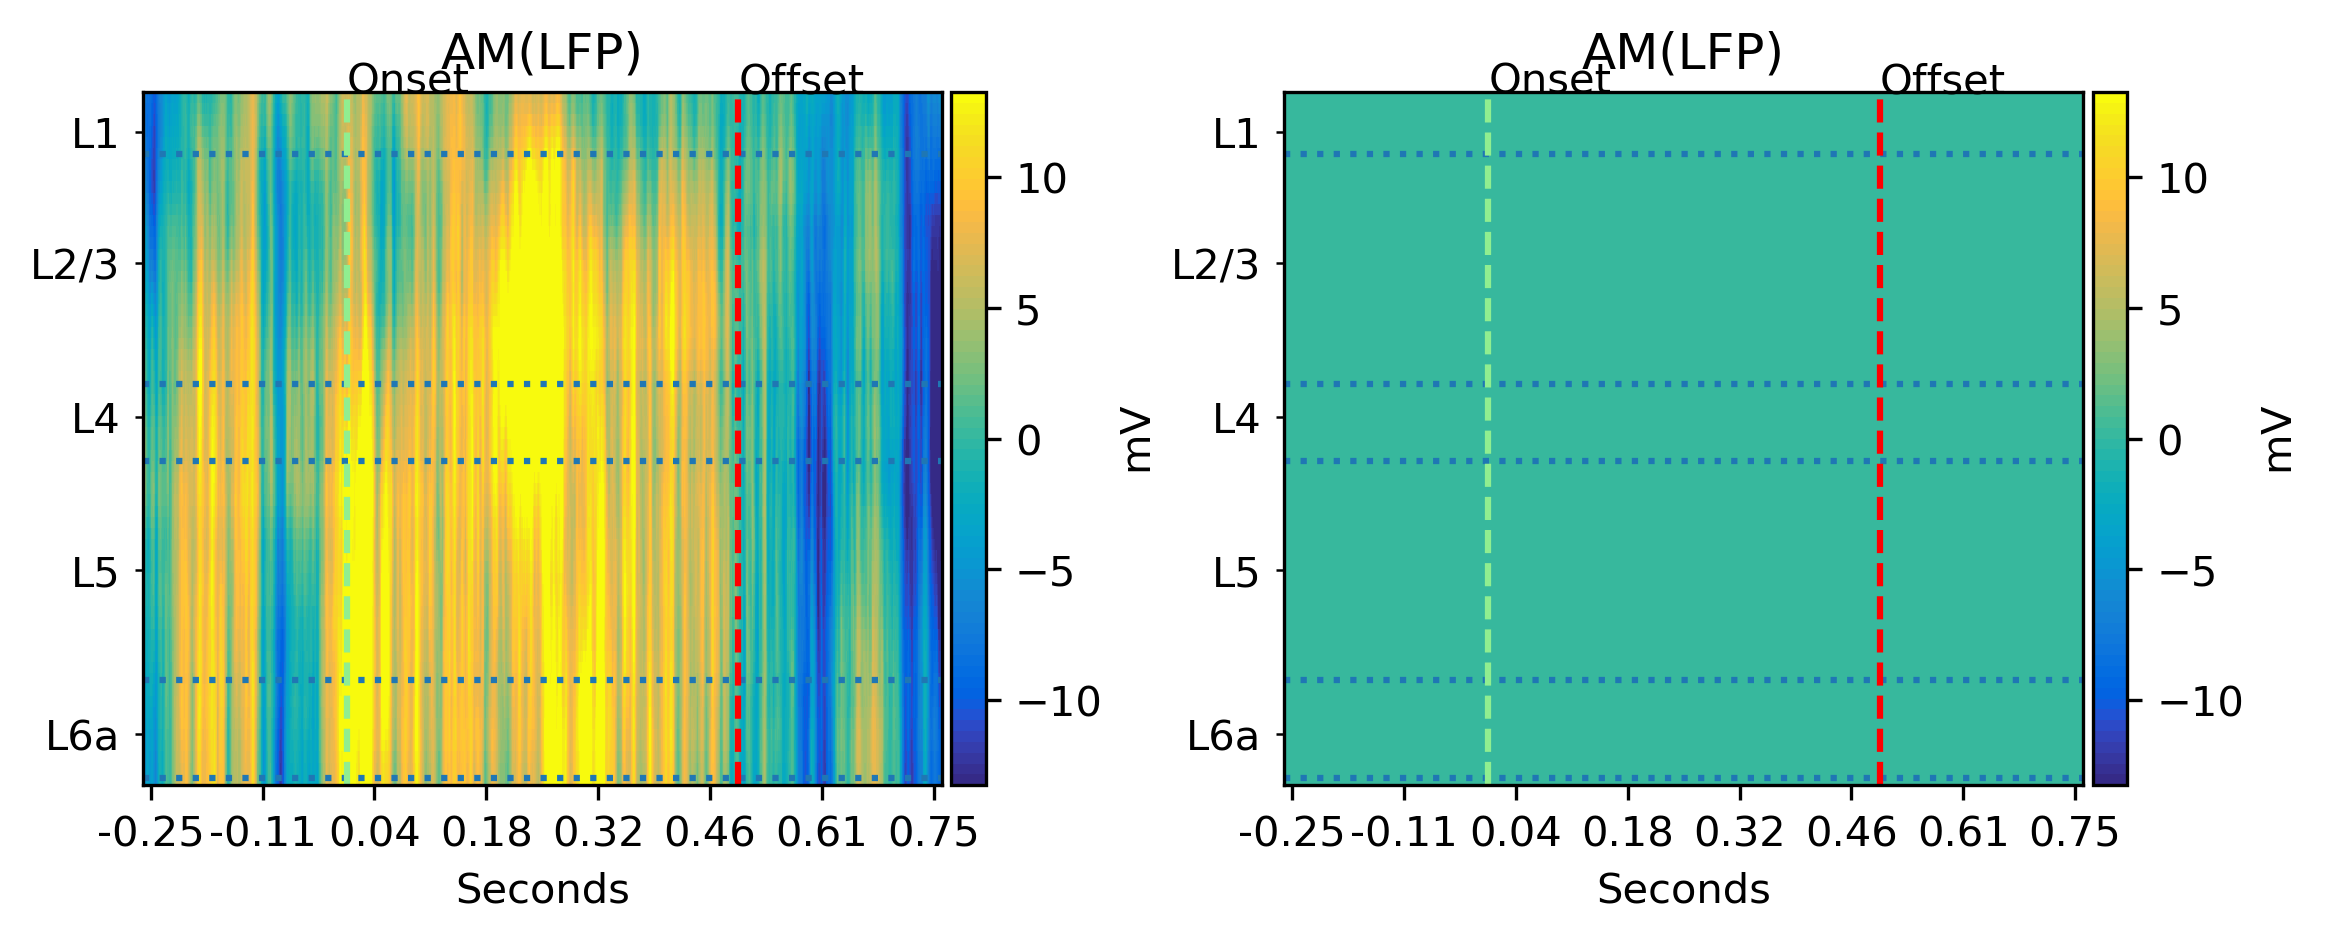

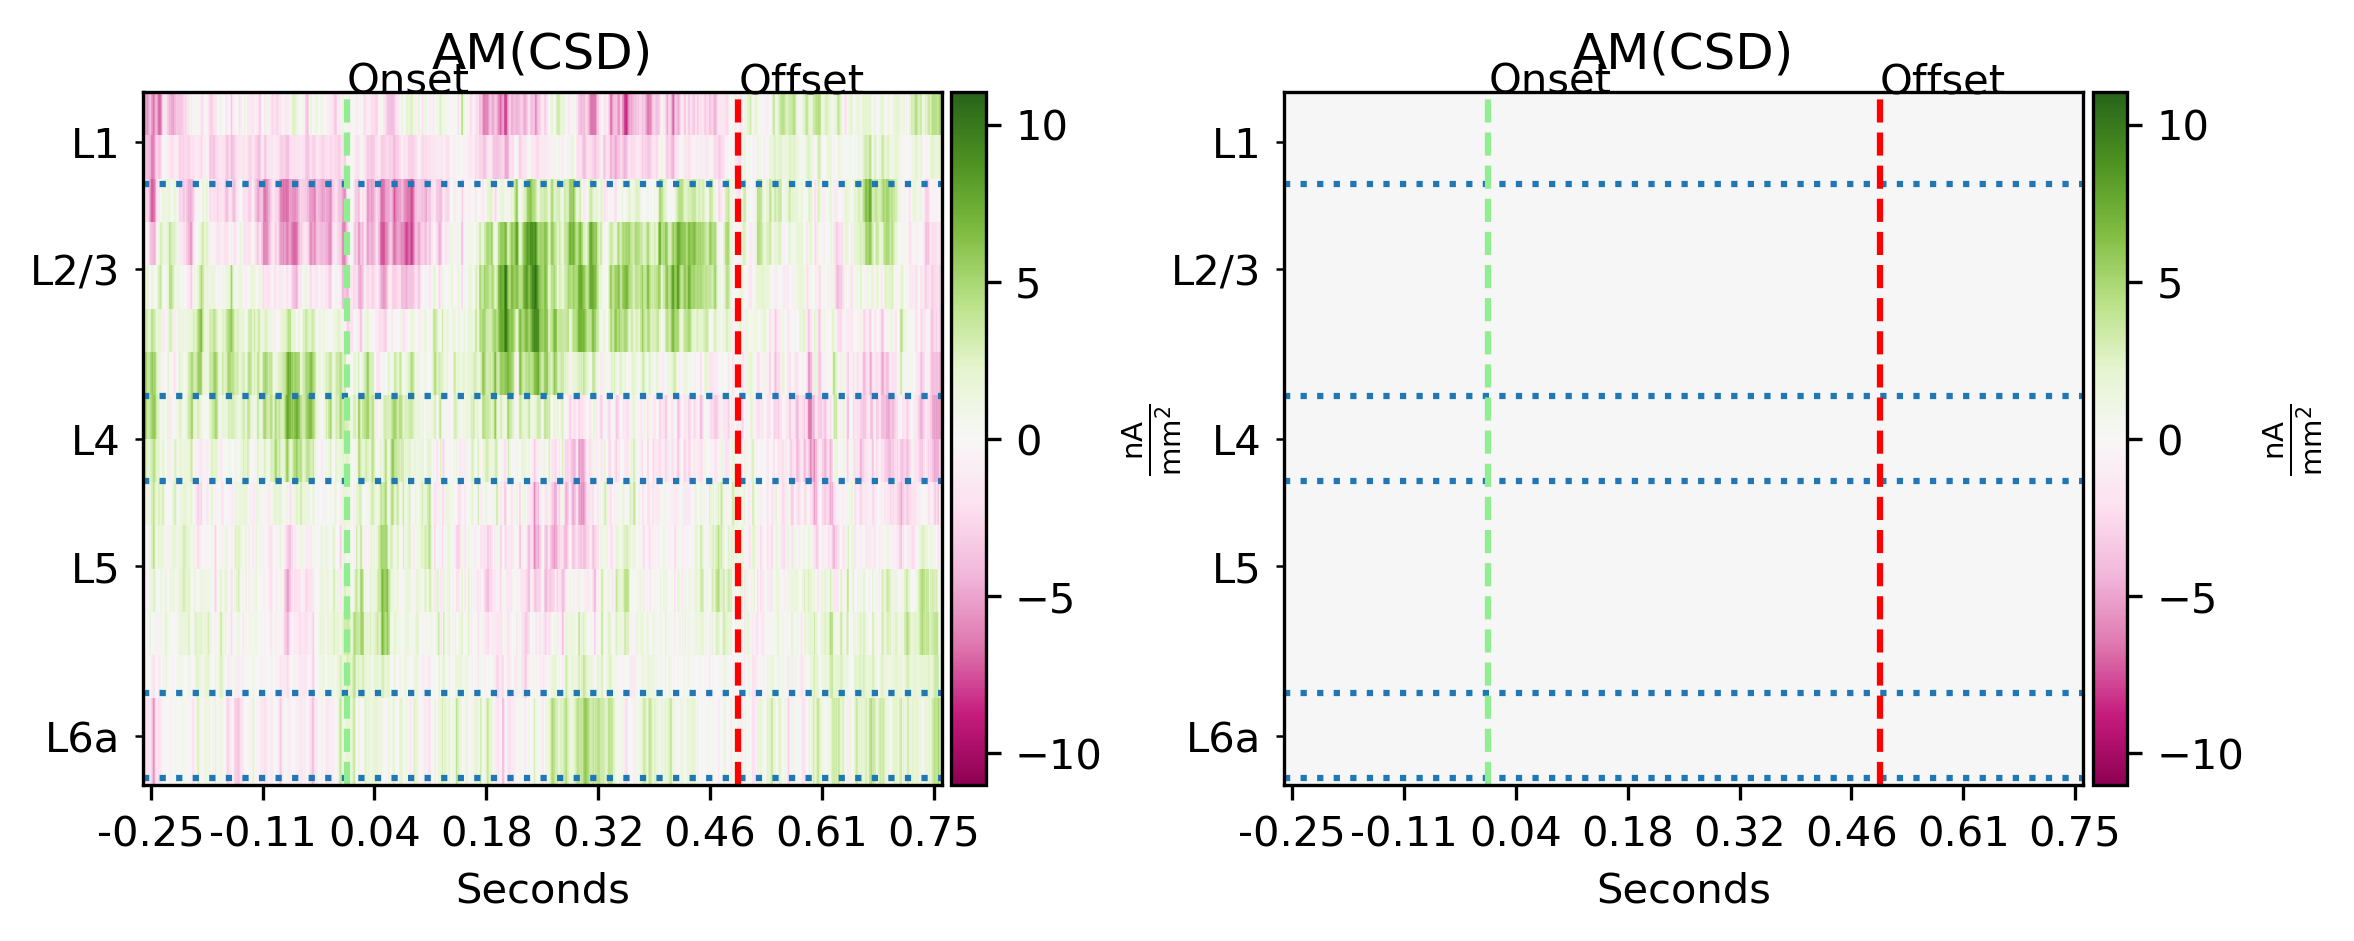

INFO:root:Plotted unmasked and masked cluster-corrected contrasts for go_contrast


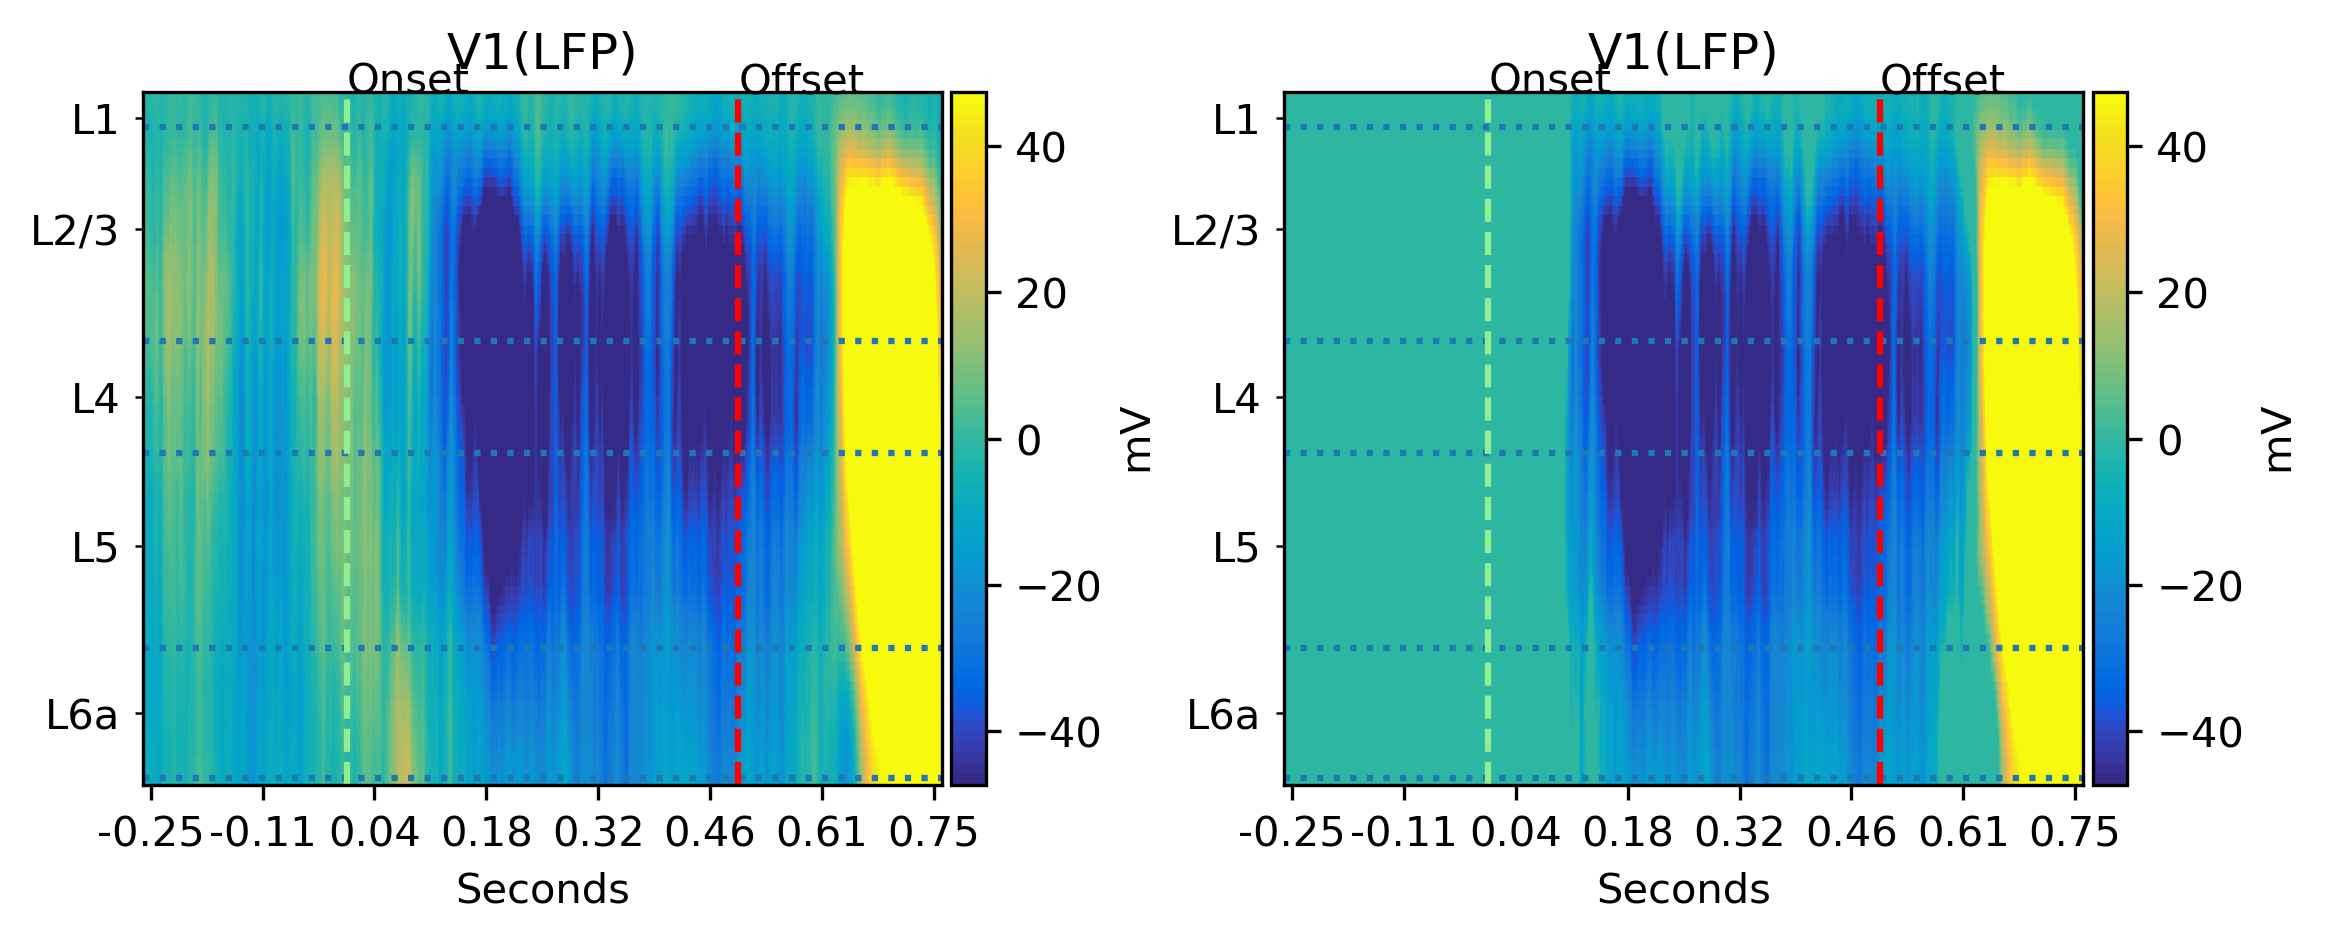

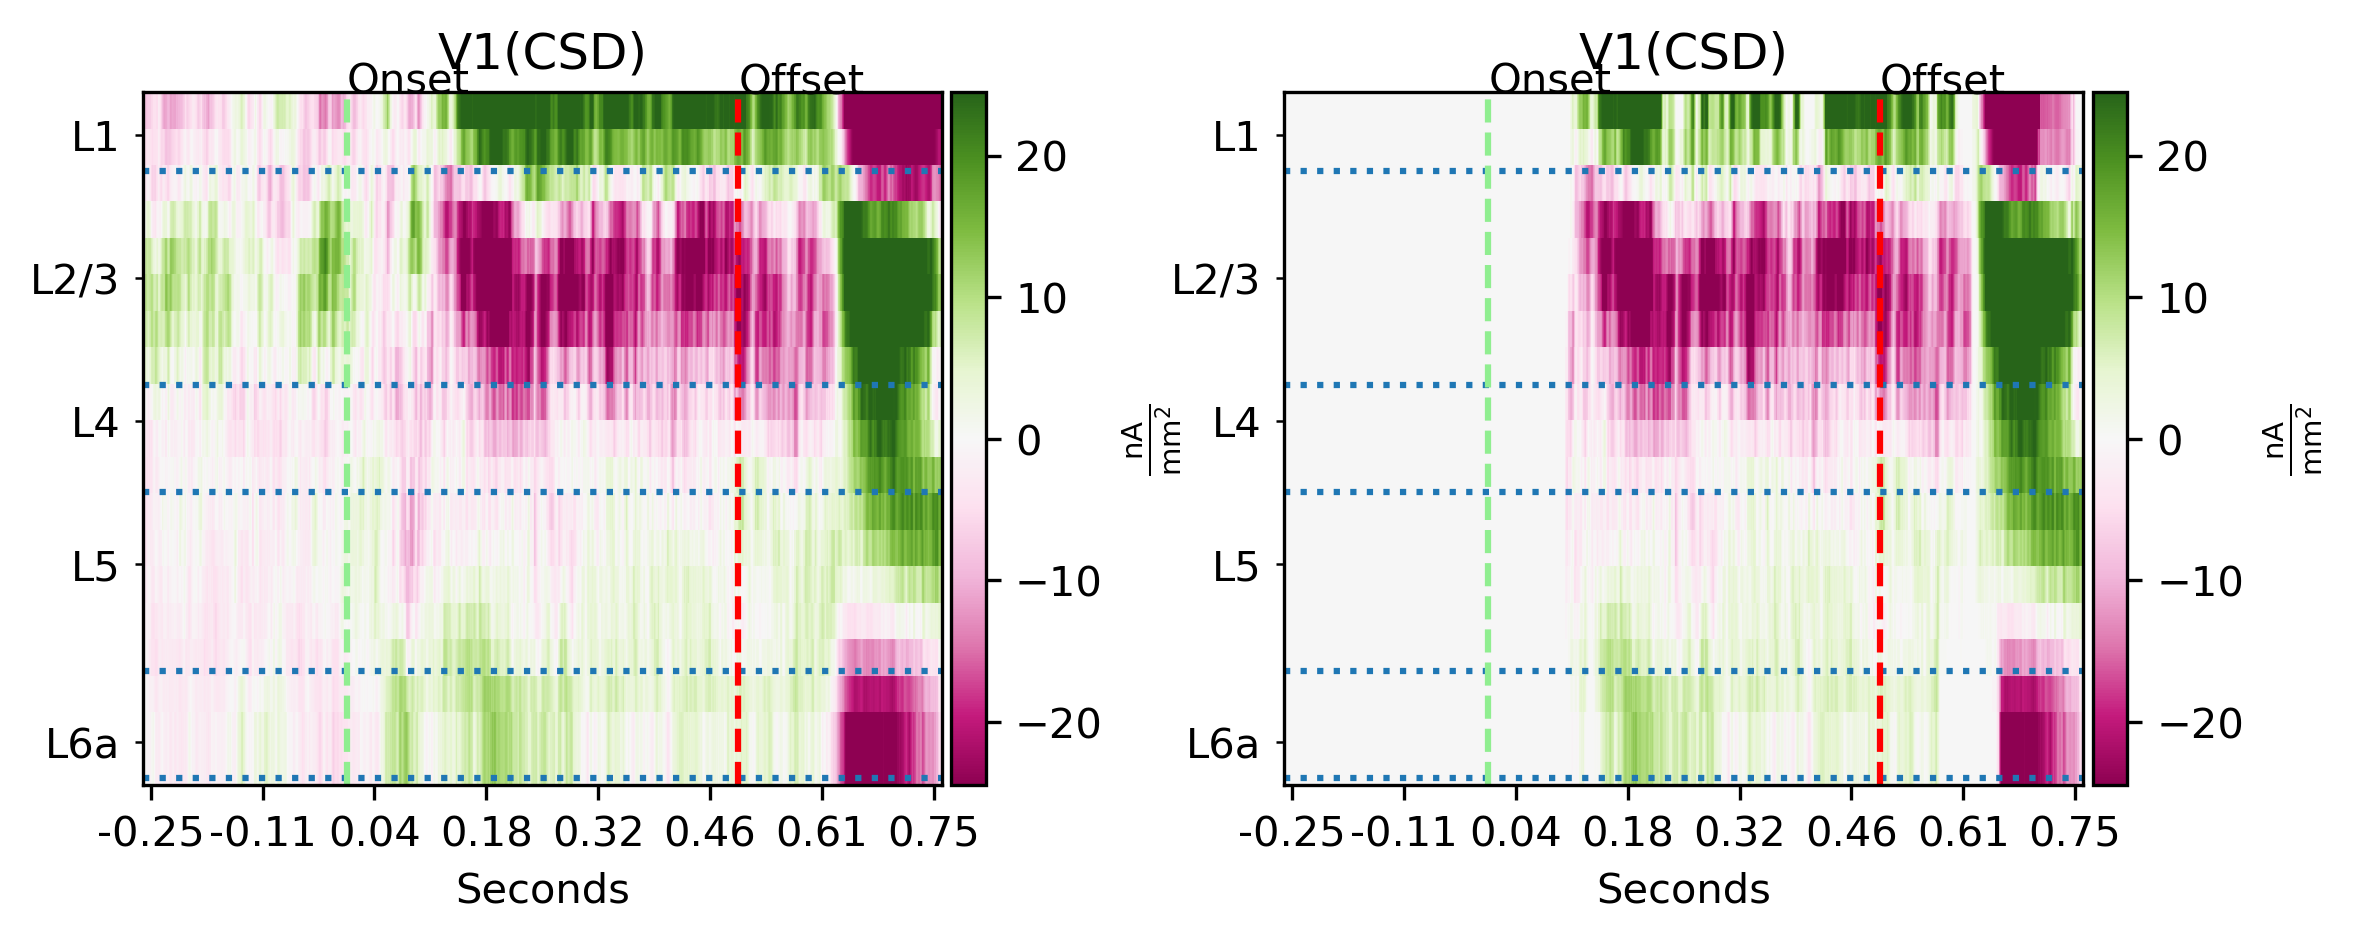

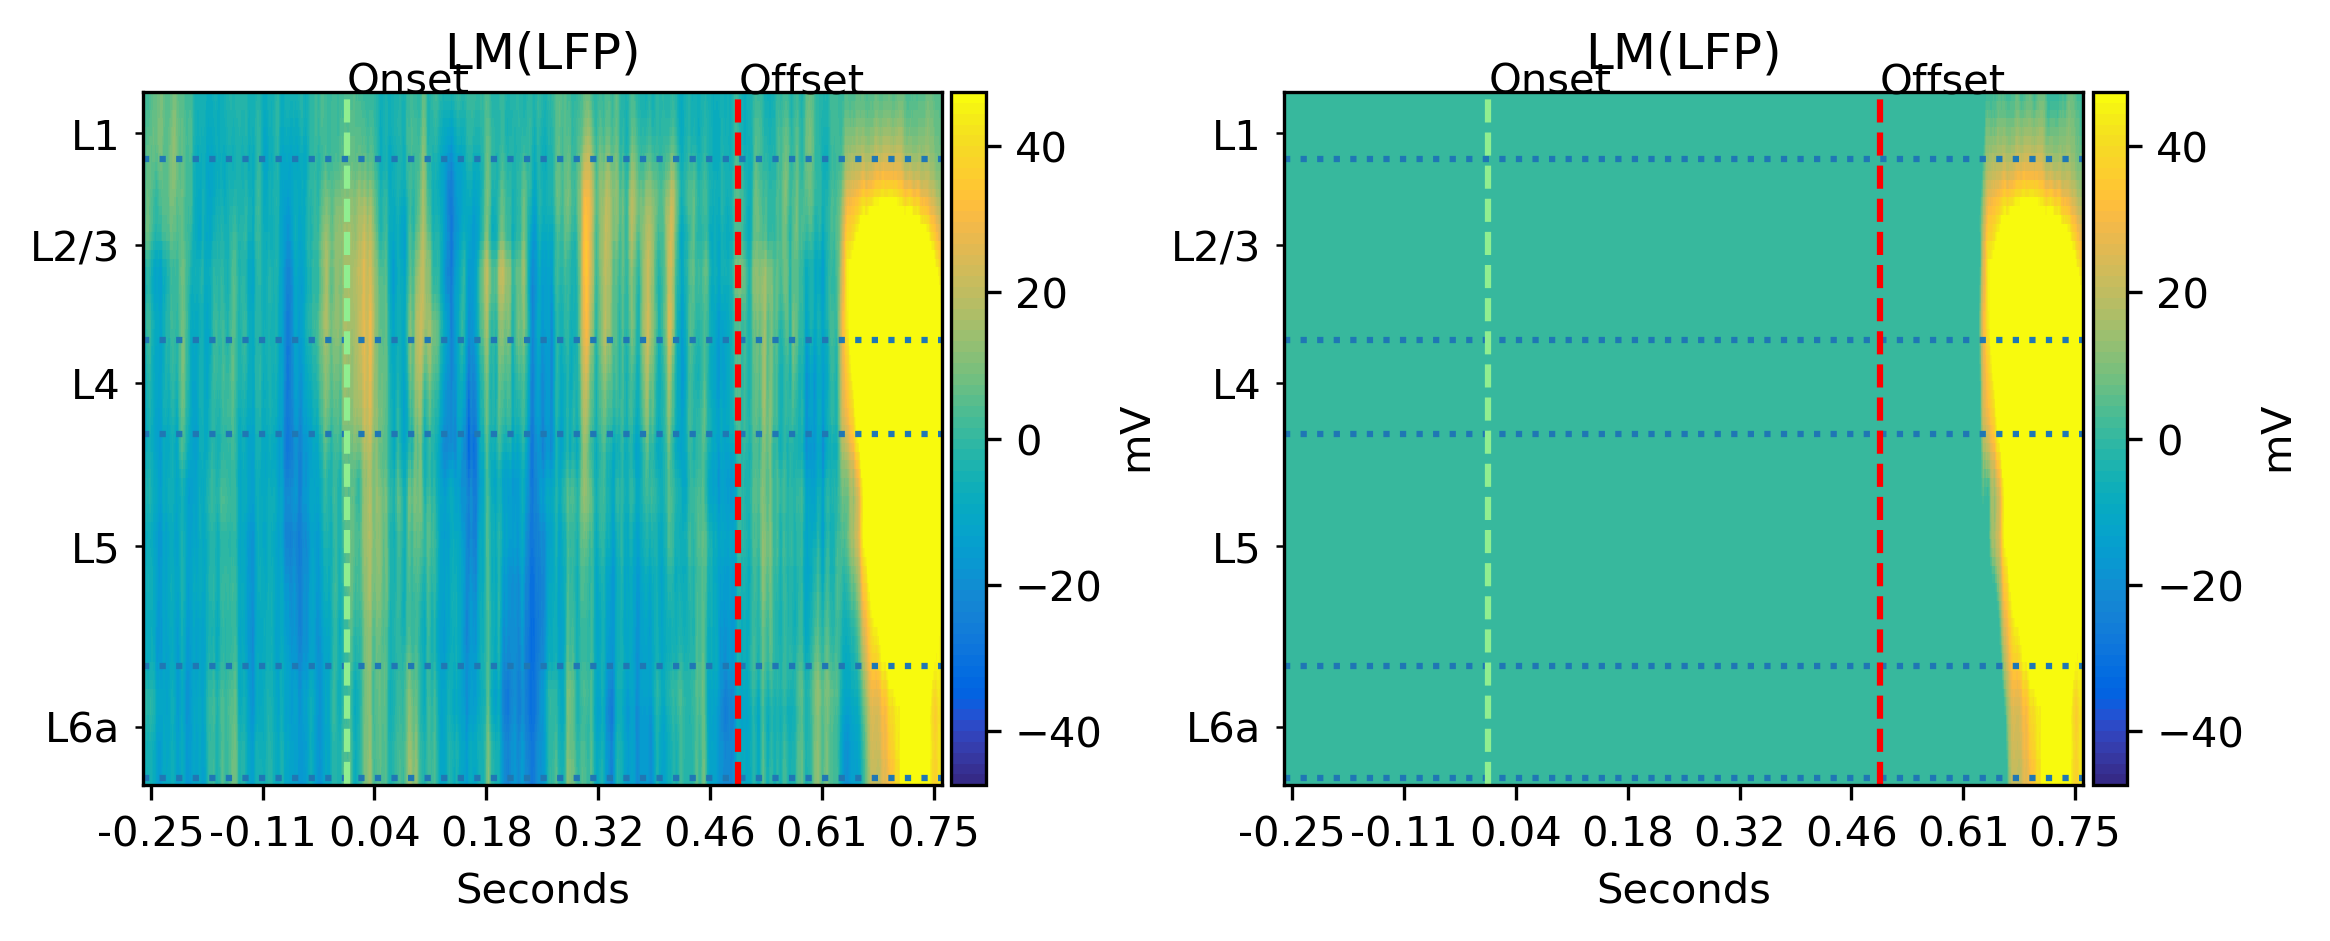

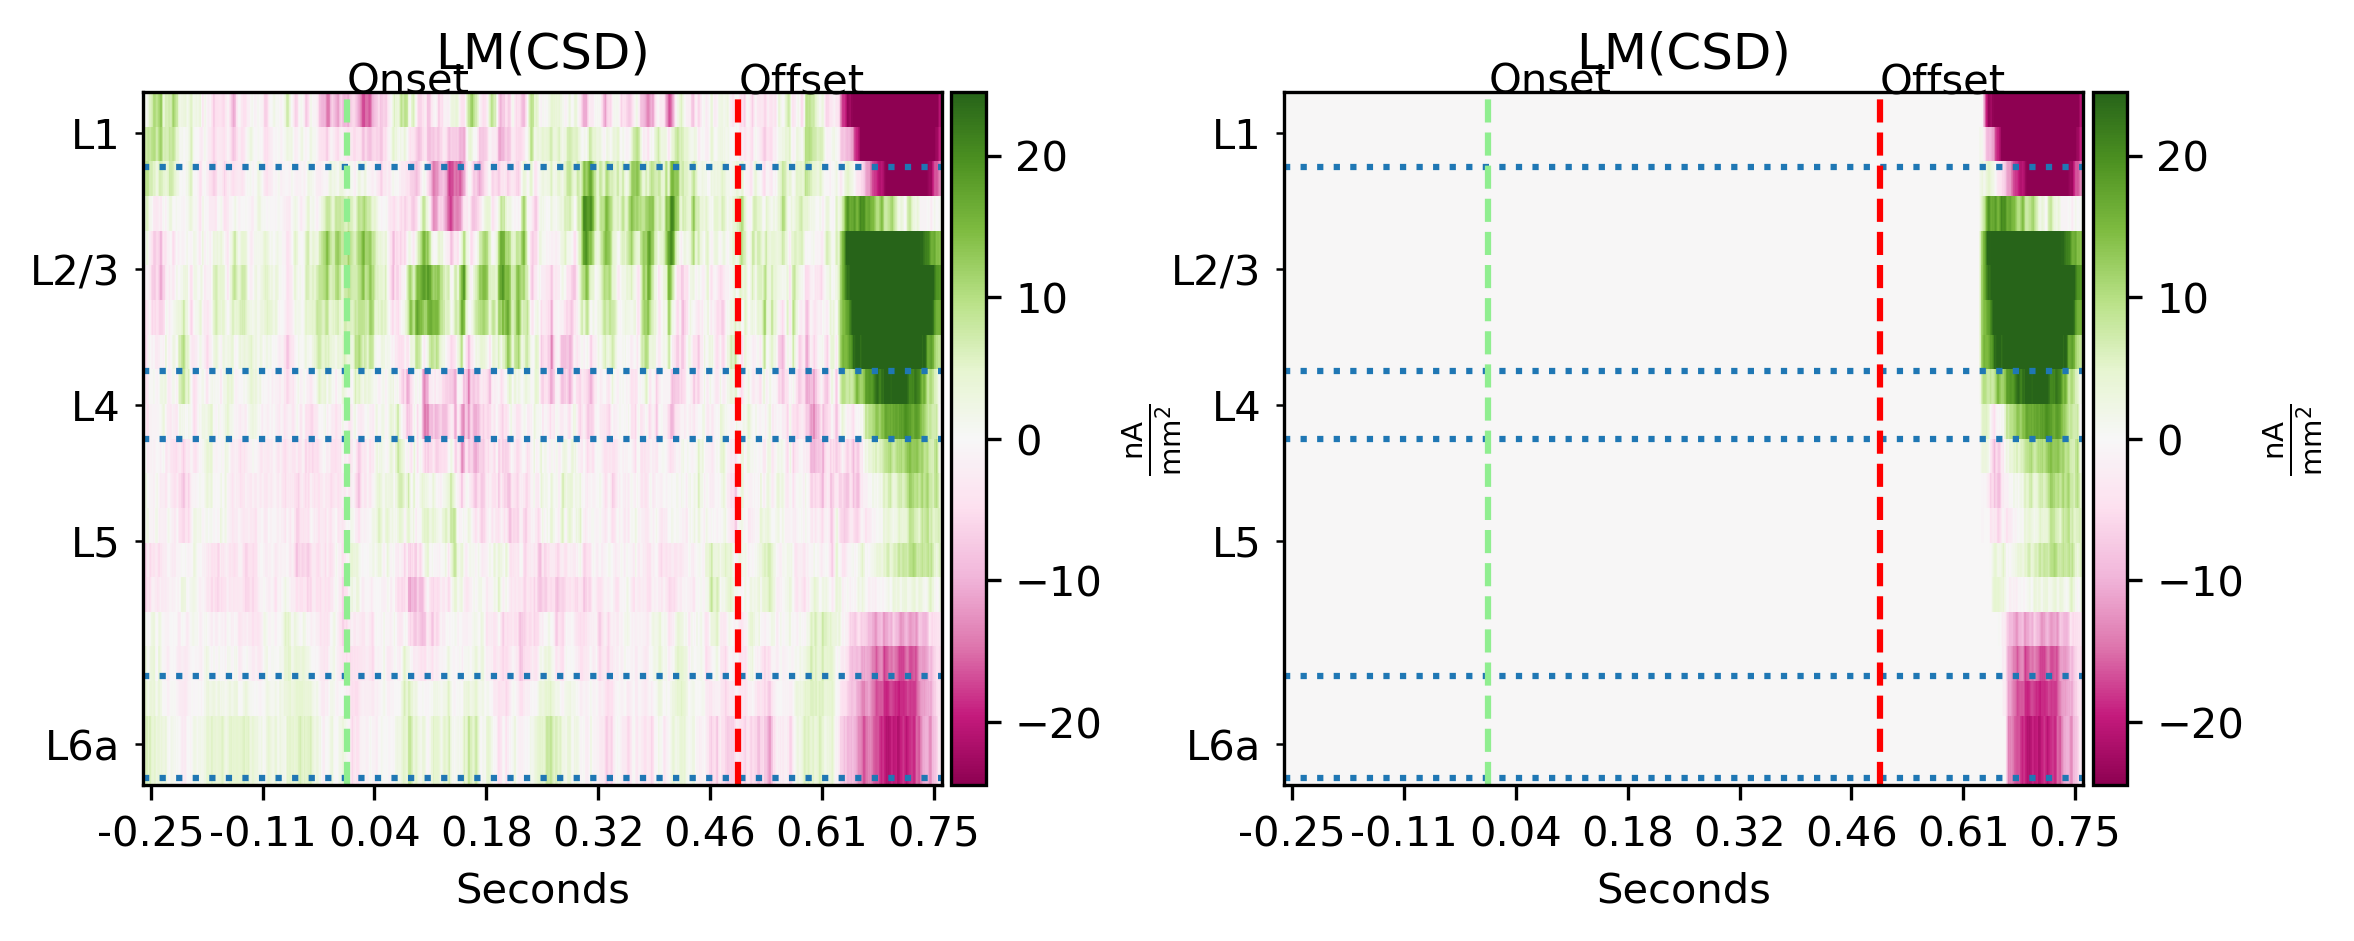

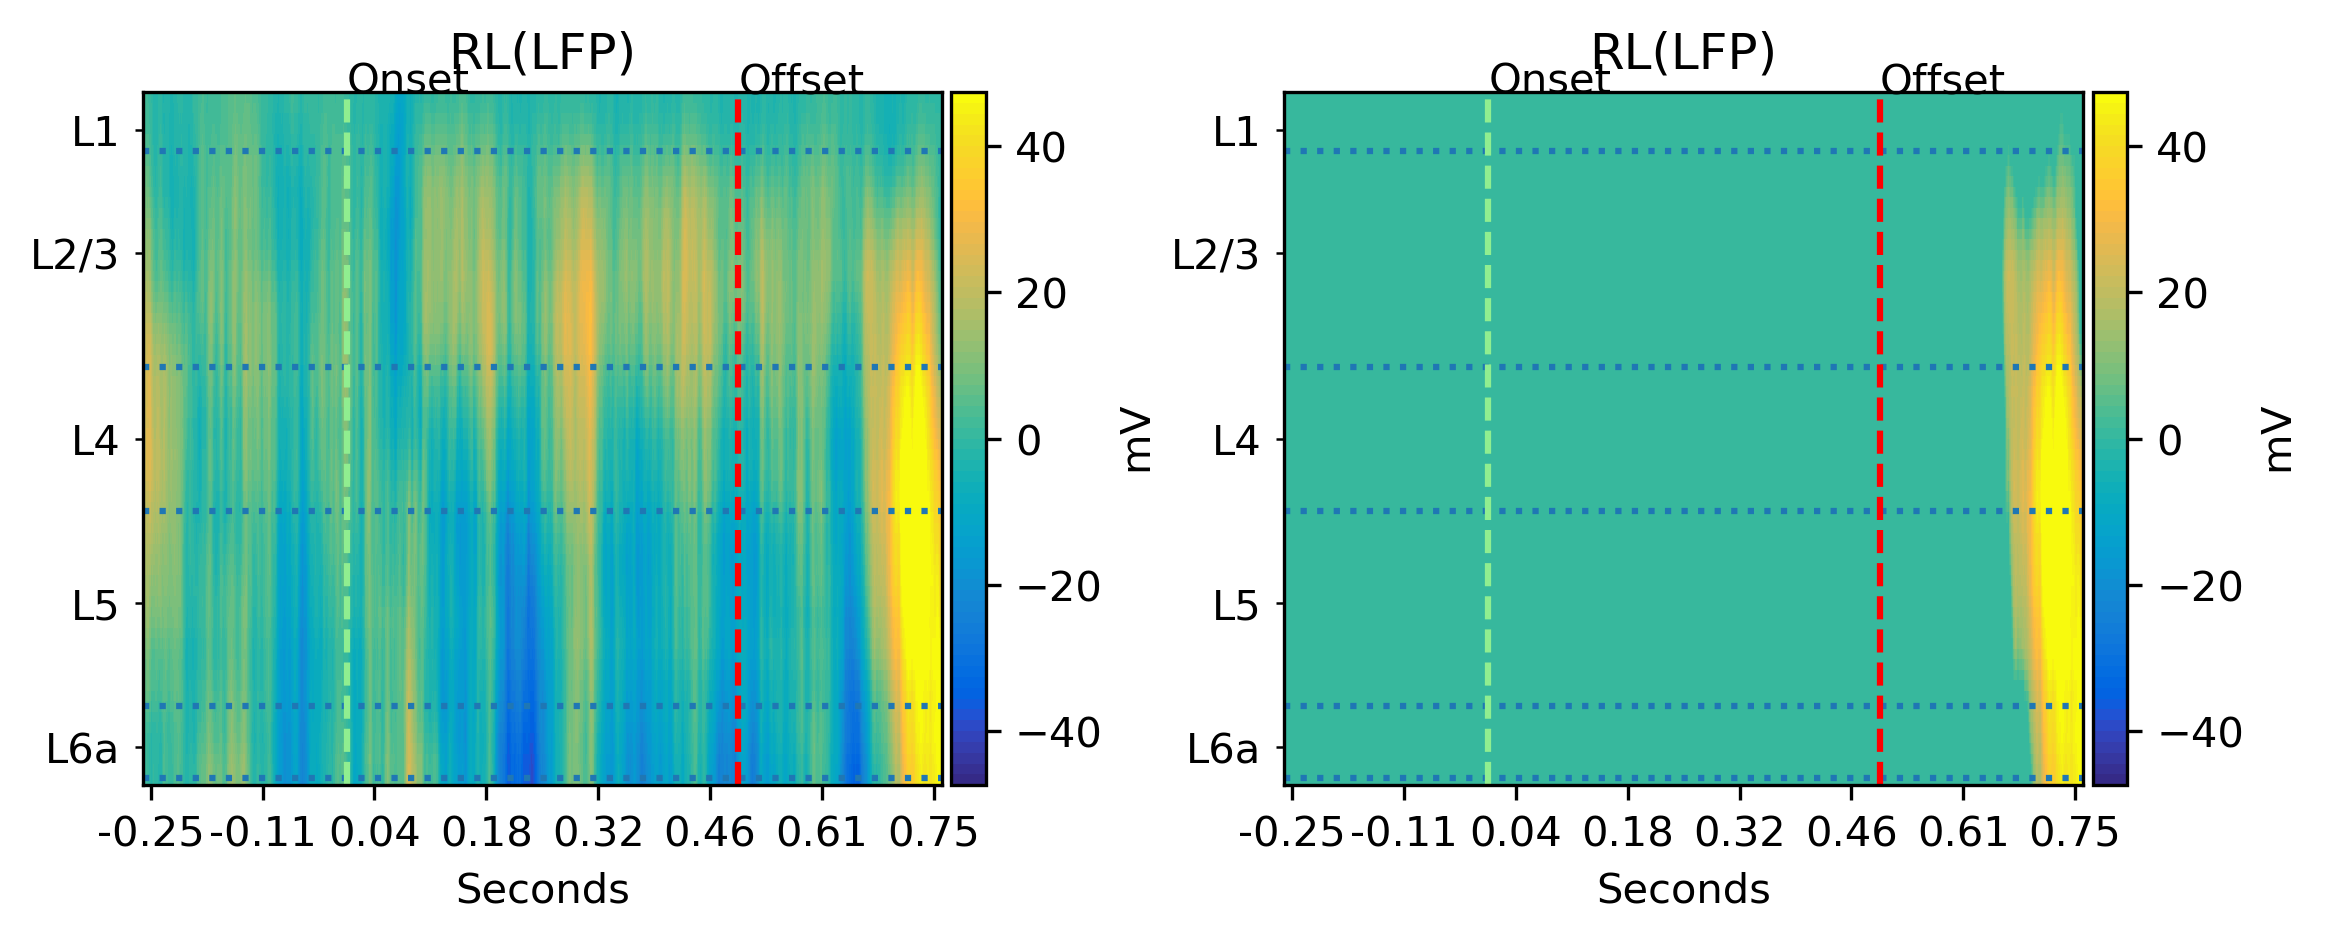

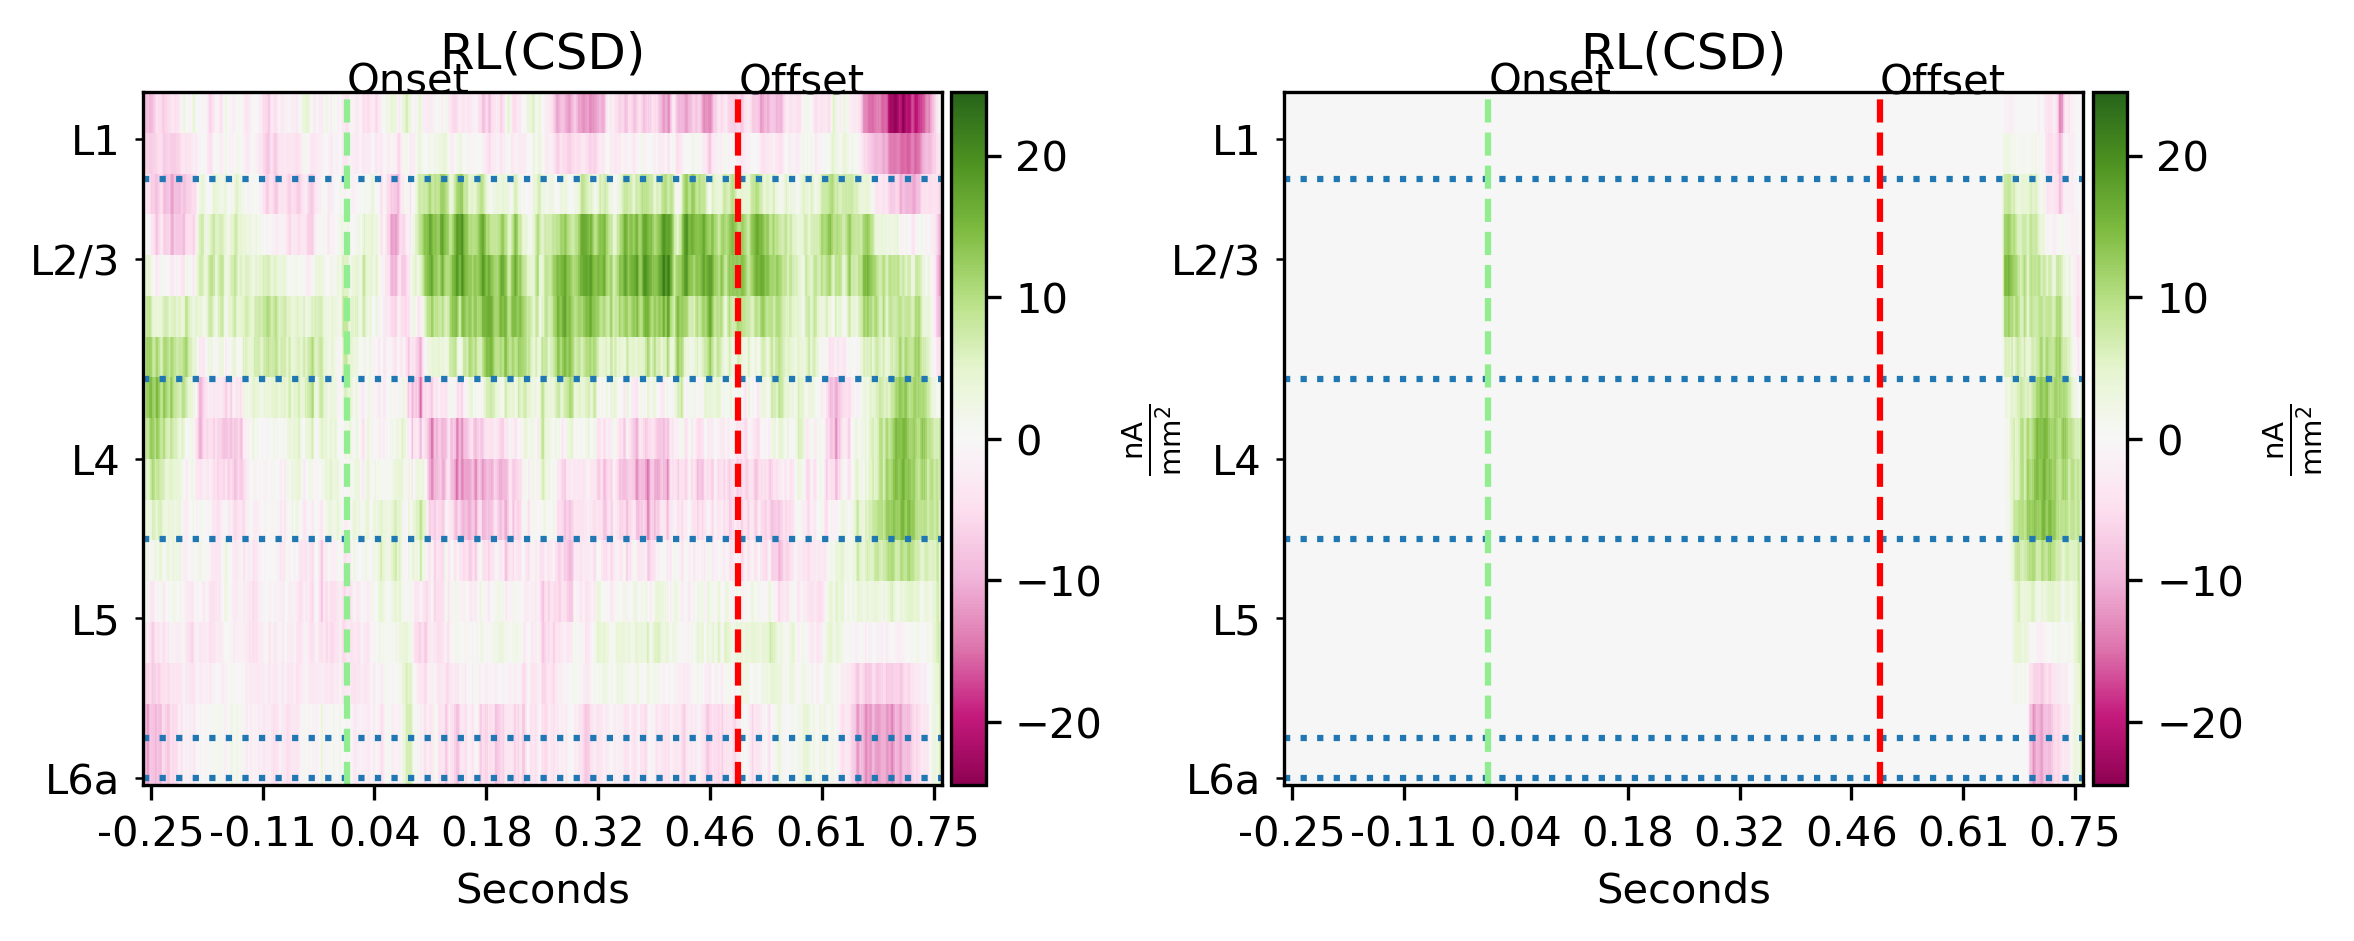

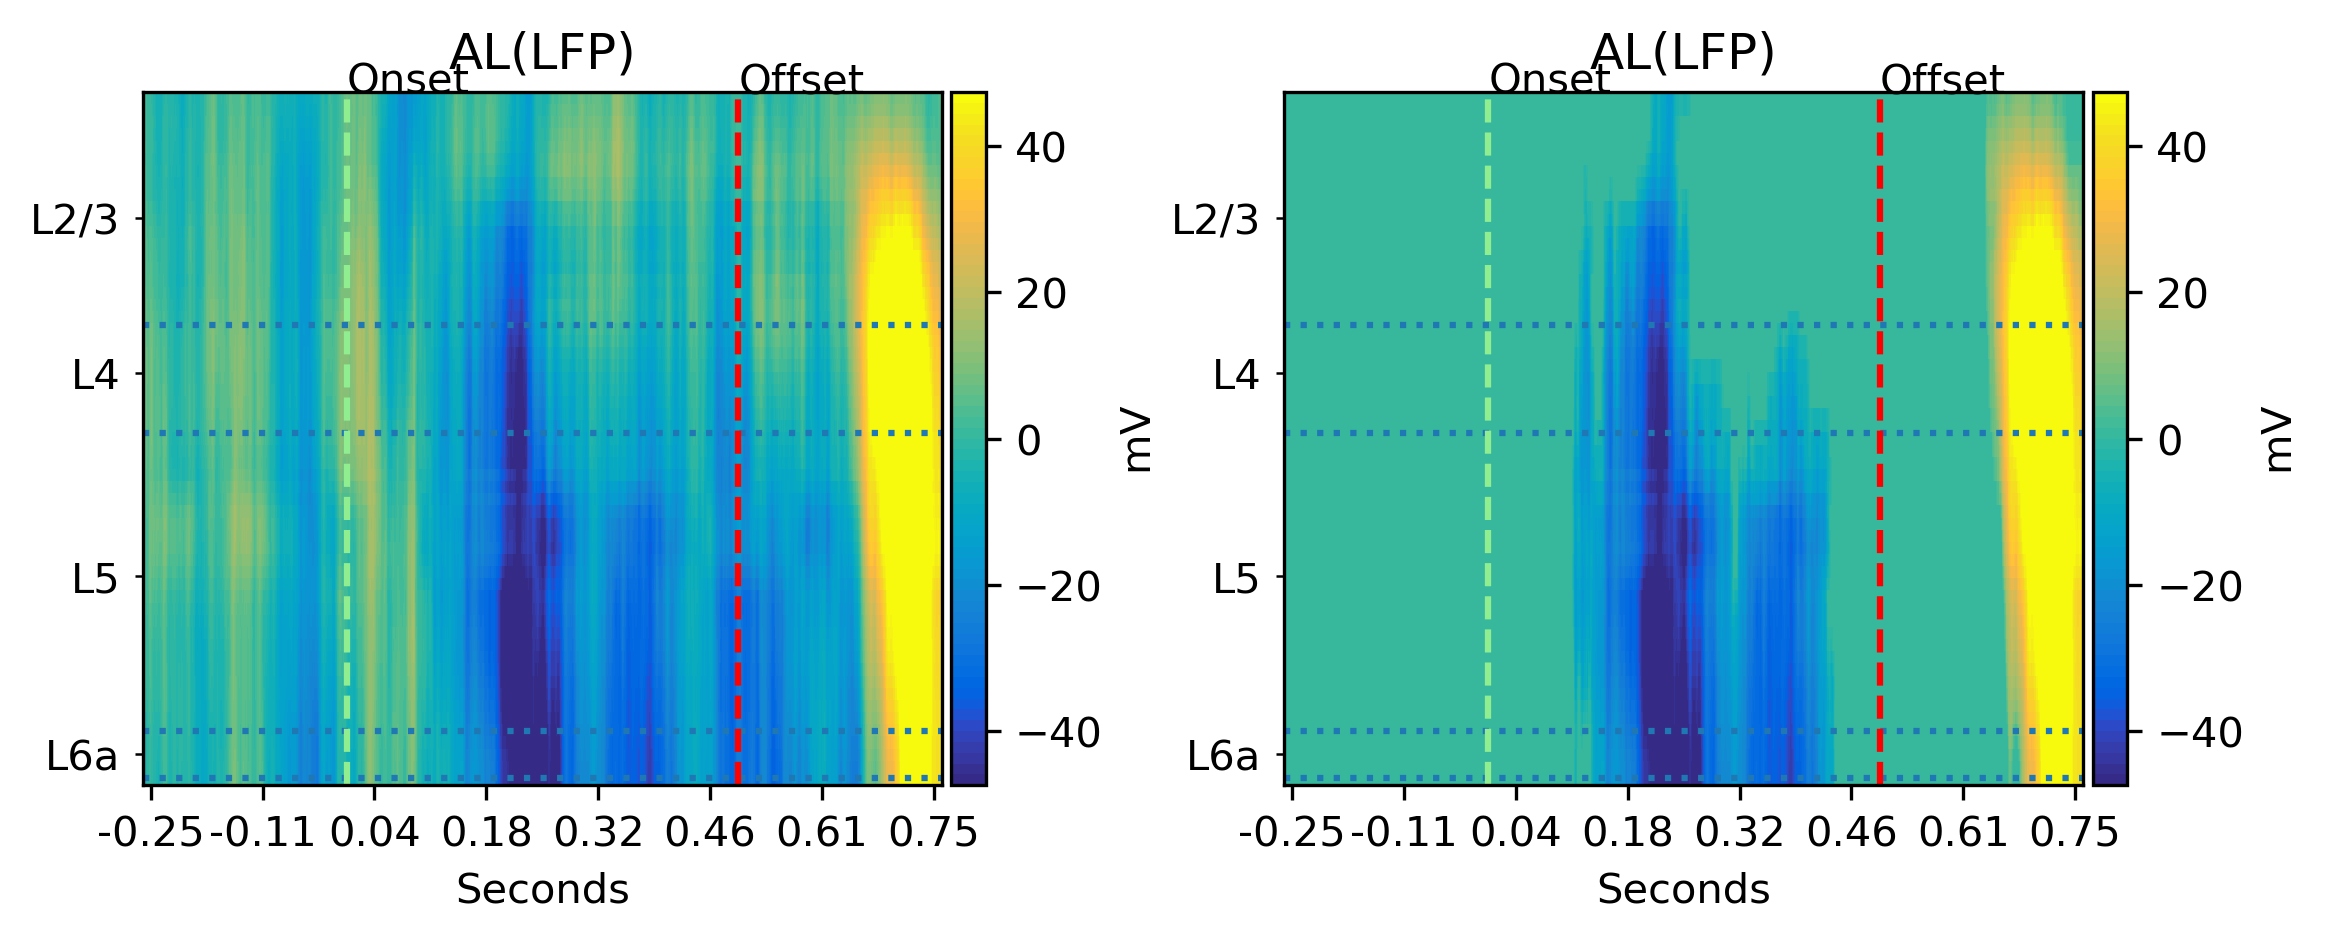

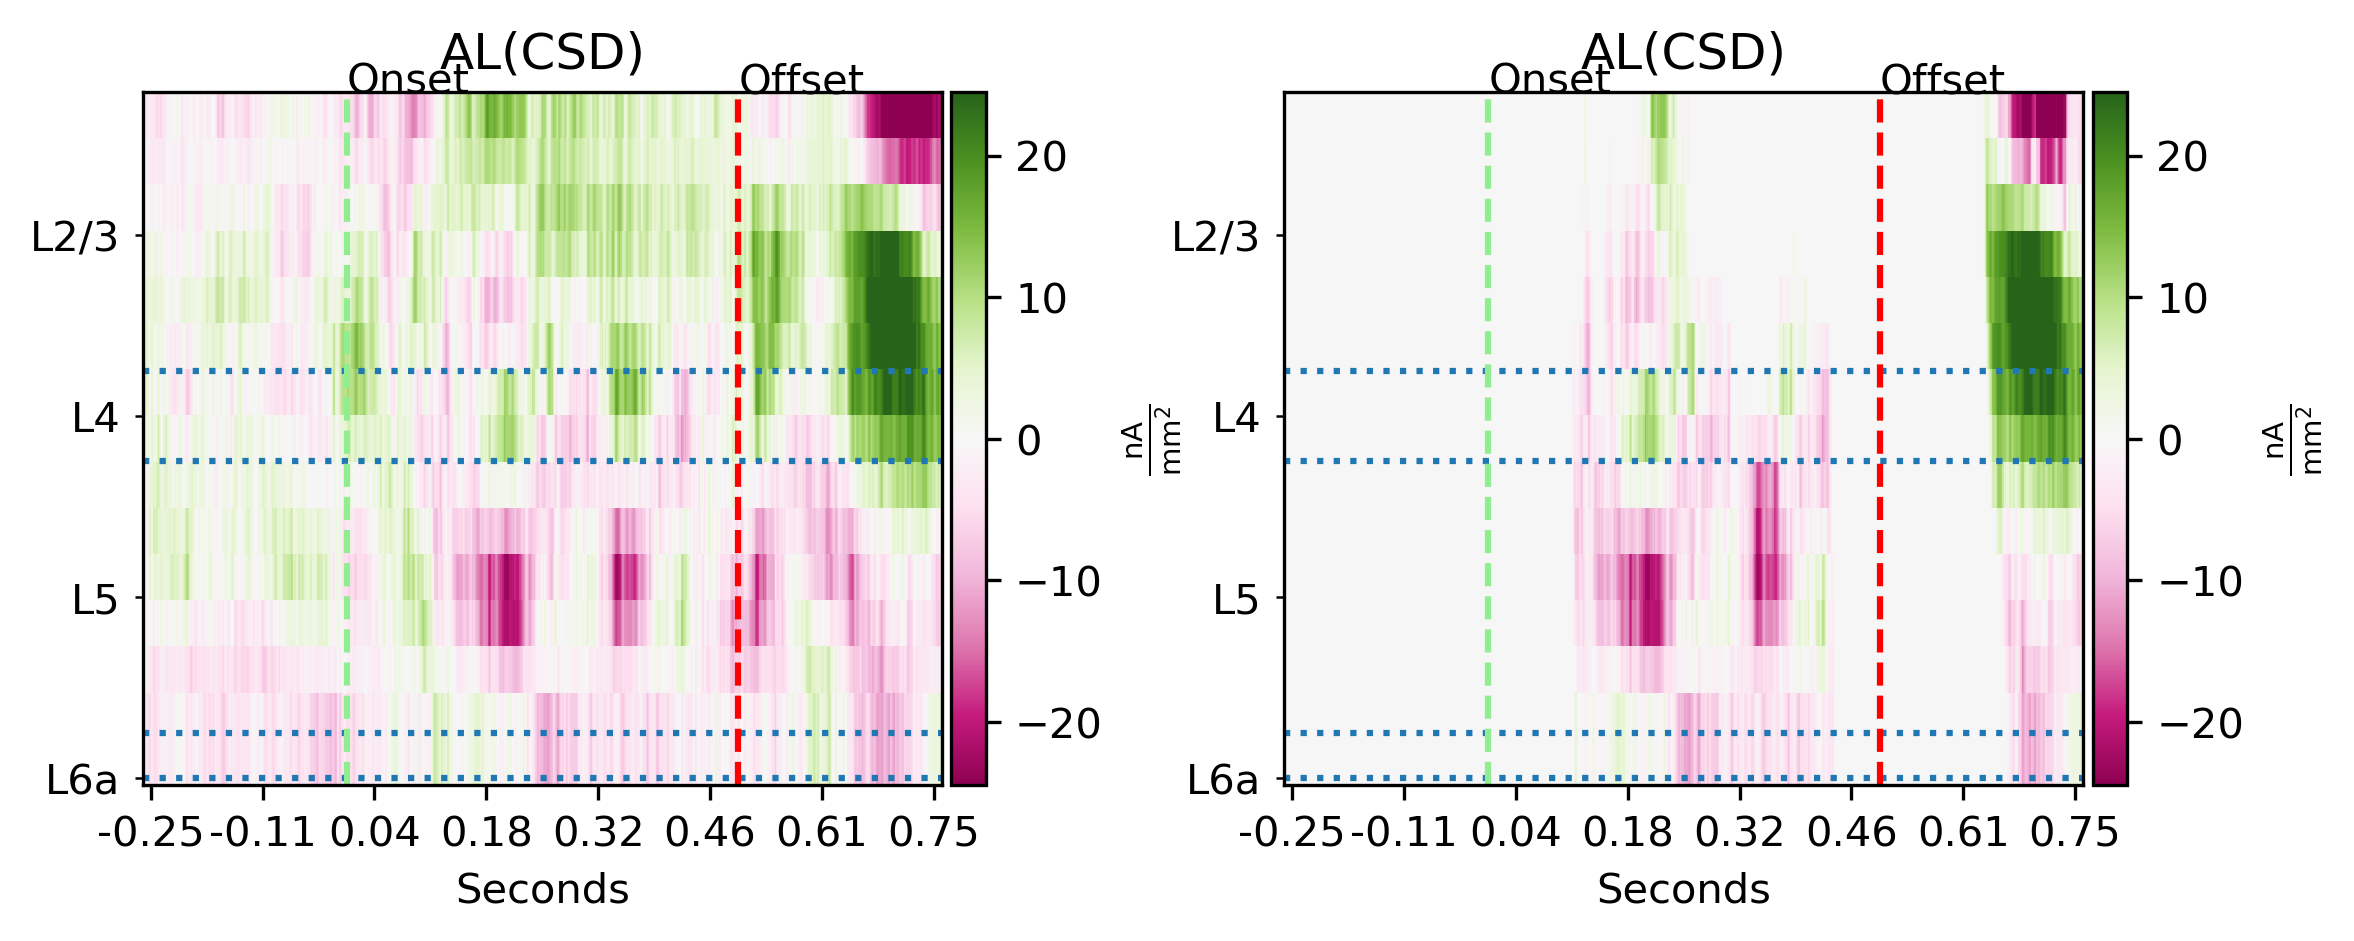

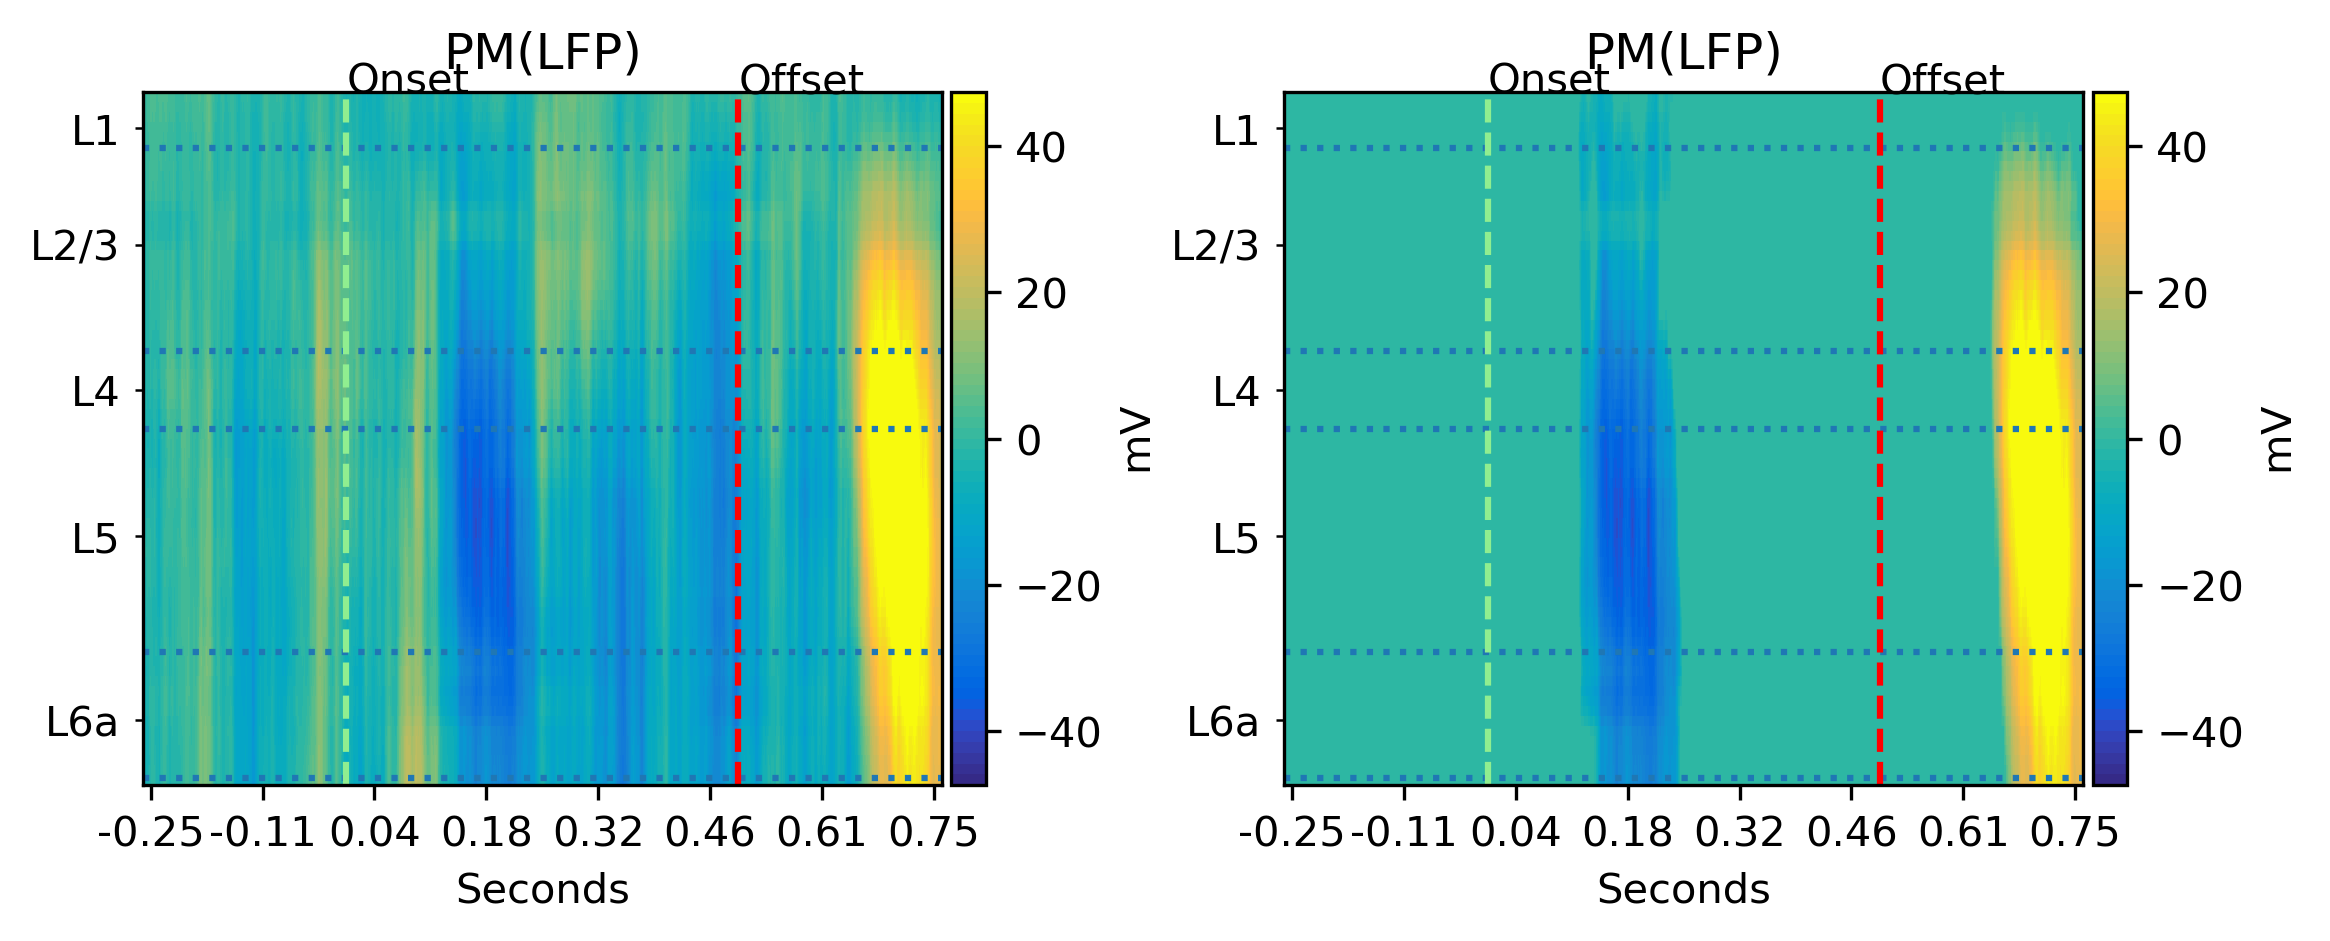

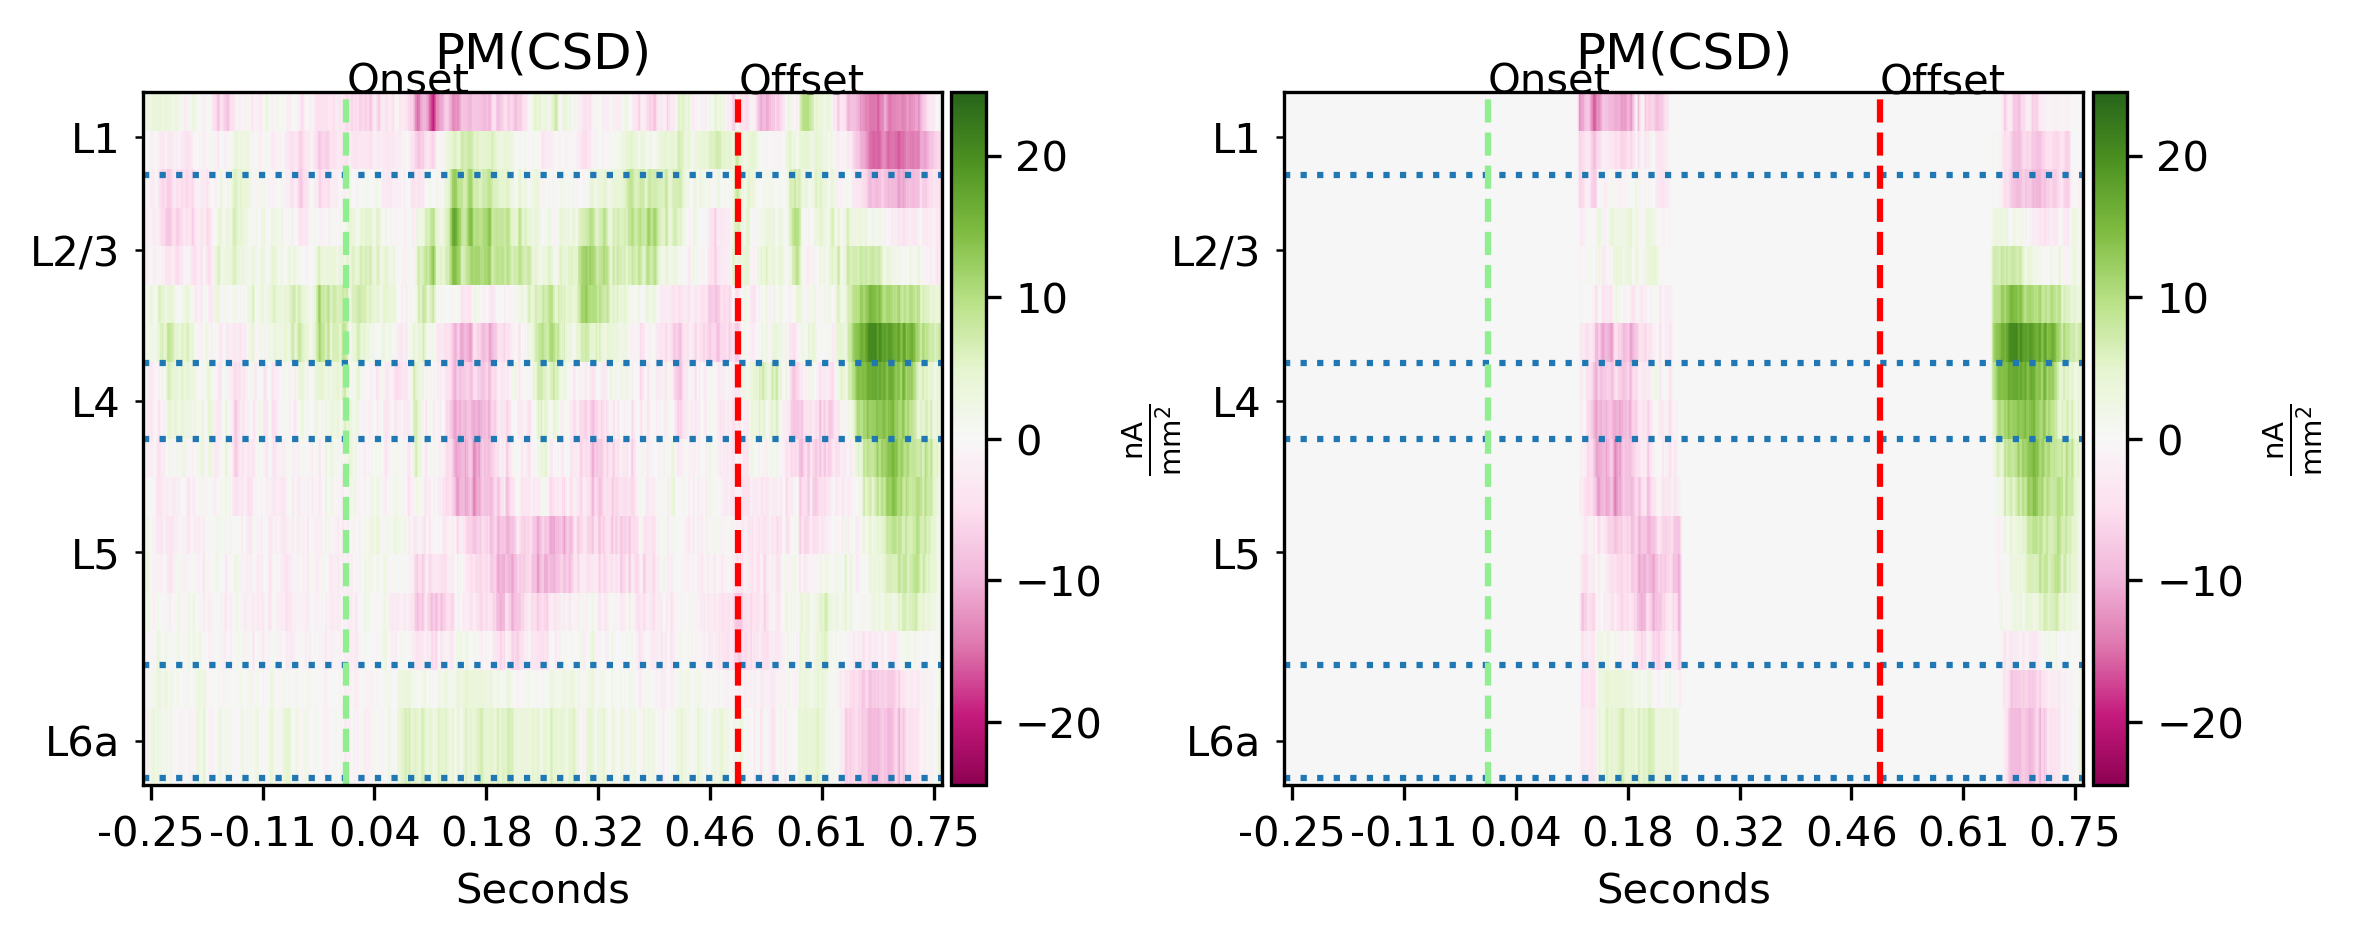

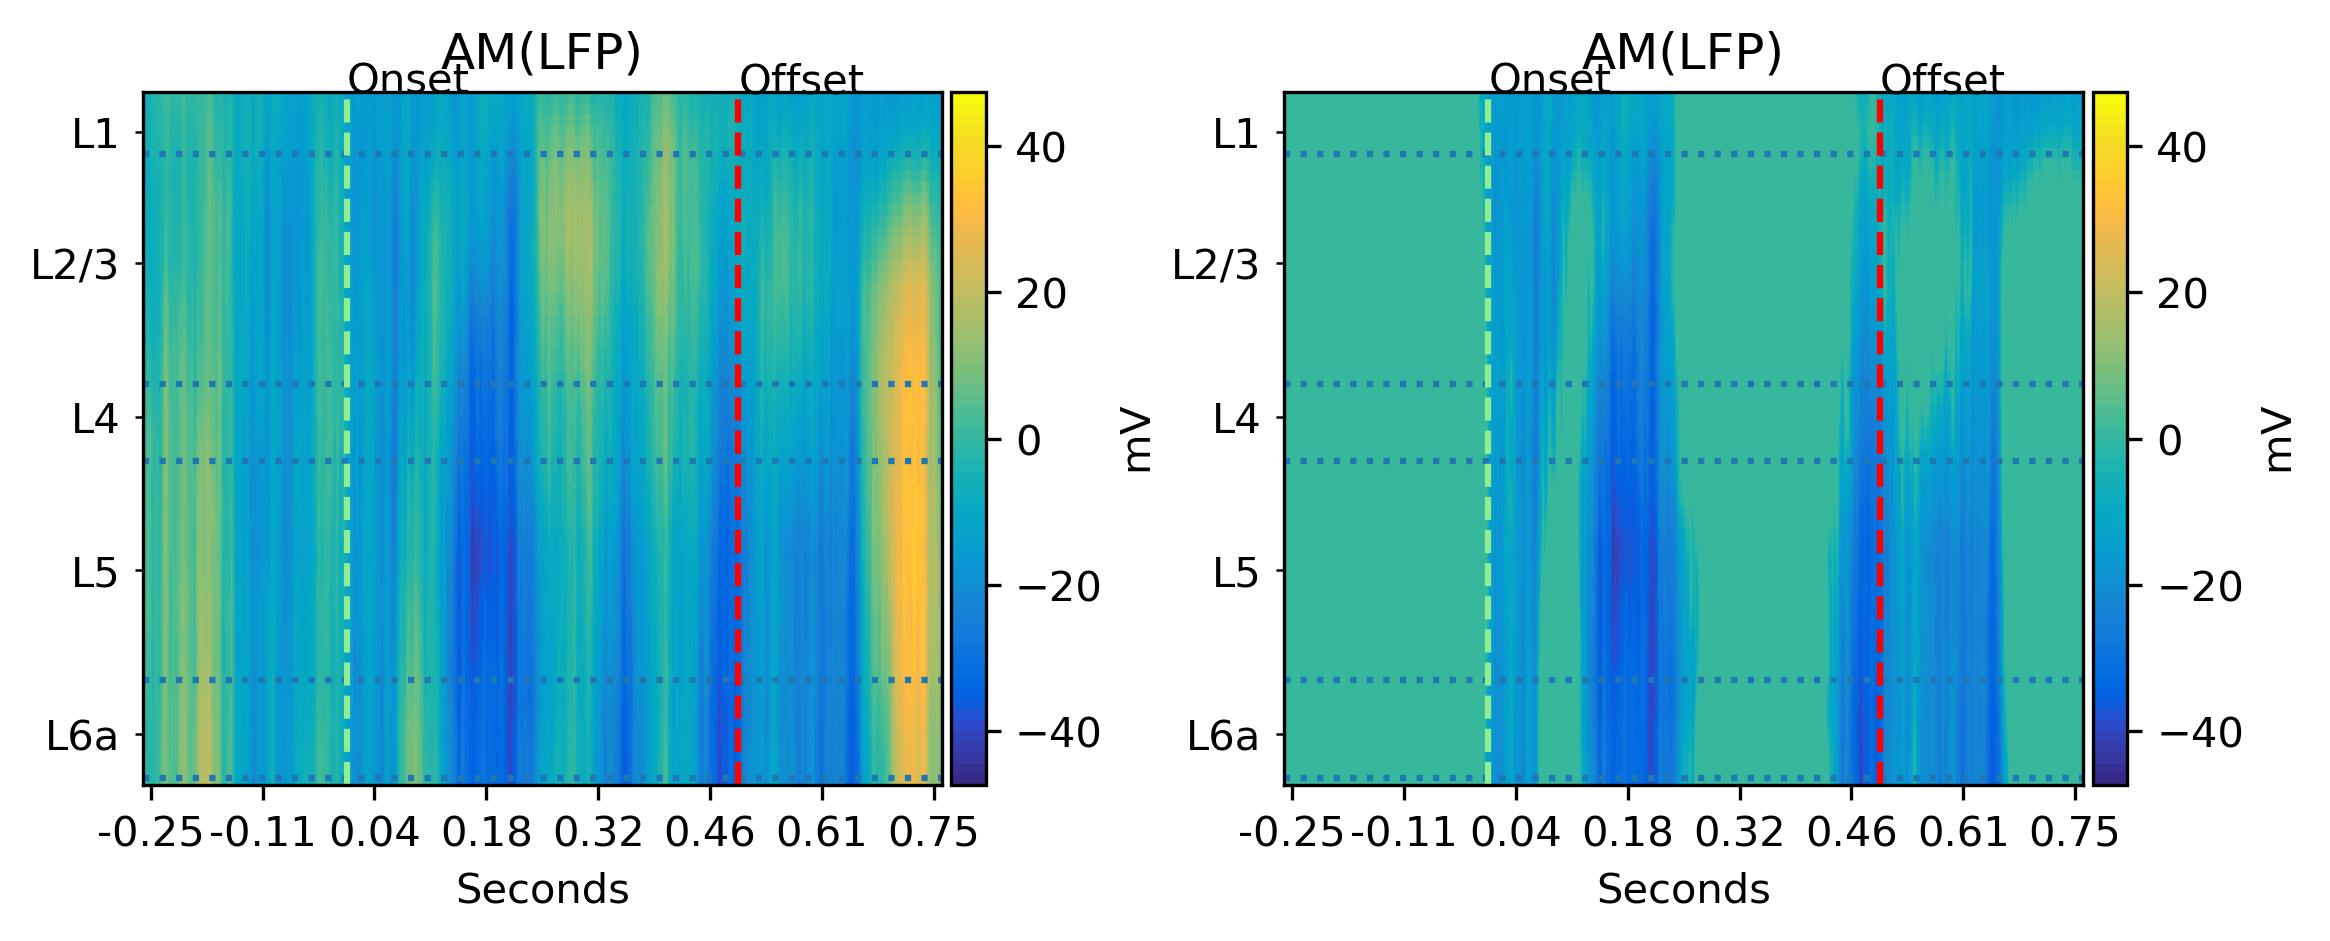

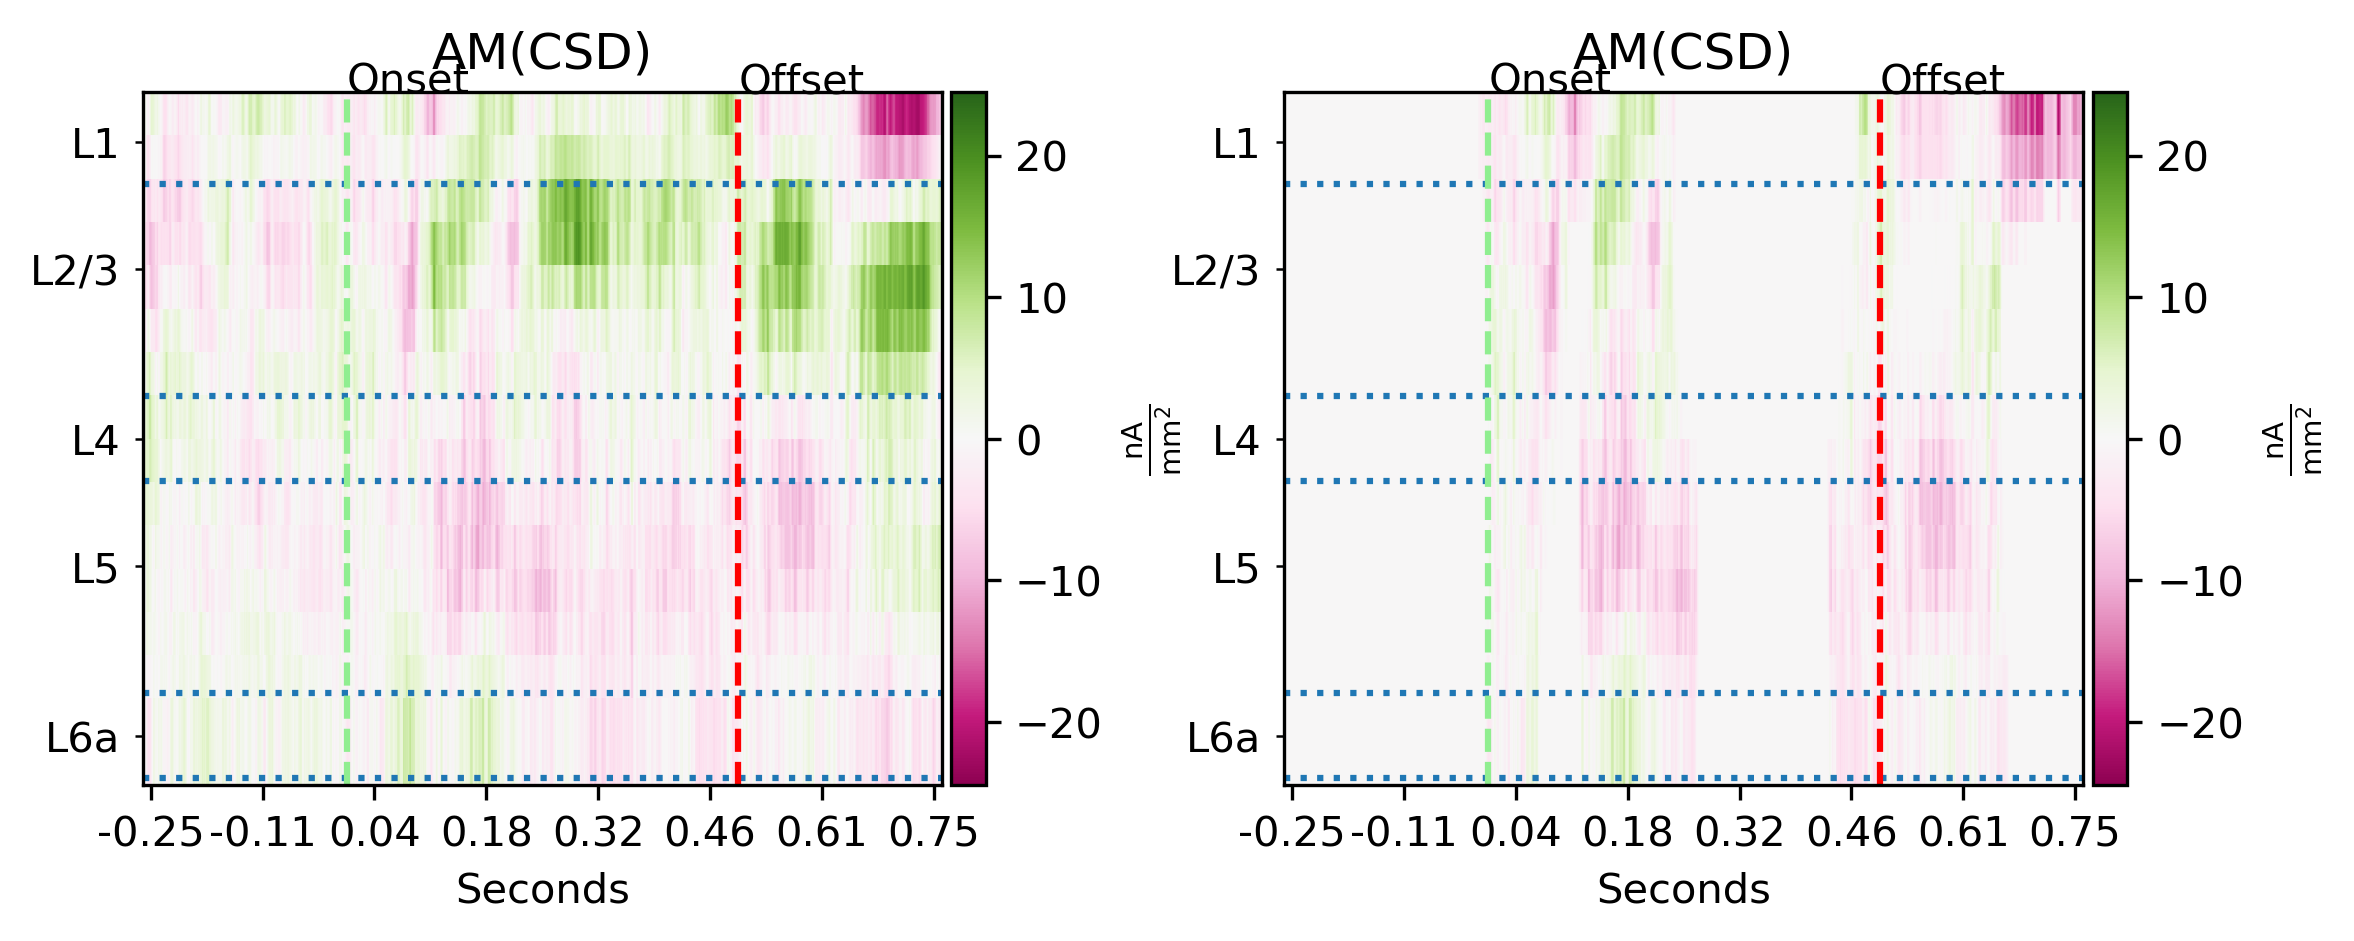

INFO:root:Plotted unmasked and masked cluster-corrected contrasts for lo_contrast


In [22]:
for (name, _, _) in CONTRASTS:
    contrast = summaries[name].results()
    csd_contrast = csd_summaries[name].results()
    lfp_sigma, csd_sigma = summaries[name].std_dev, csd_summaries[name].std_dev
    for area in anatomical_areas:
        mask, lfp = contrast[area]["mask"], contrast[area]["signal"]
        masked_lfp = lfp.fmap(lambda data: data * mask[:, :, np.newaxis])
        title = area_titles[area]
        
        fig, axes = plt.subplot_mosaic([[False, True]],
                                       figsize=(9, 3), dpi=300)
        for masking, ax in axes.items():
            sig = masked_lfp if masking else lfp
            sig.plot(ax=ax, fig=fig, title=title + "(LFP)", events=EVENTS,
                     vmin=-2 * lfp_sigma, vmax=2 * lfp_sigma, cbar=True)
        plt.show()
        fig.savefig(contrast_path(name) + "/" + area + '_lfp.pdf', bbox_inches='tight')
        fig.savefig(contrast_path(name) + "/" + area + '_lfp.png', bbox_inches='tight')
        fig.savefig(contrast_path(name) + "/" + area + '_lfp.svg', bbox_inches='tight')

        csd = csd_contrast[area]['signal']
        masked_csd = csd.fmap(lambda data: data * csd_contrast[area]['mask'][:, :, np.newaxis])
        sigma = csd.data.std()

        fig, axes = plt.subplot_mosaic([[False, True]],
                                       figsize=(9, 3), dpi=300)
        for masking, ax in axes.items():
            sig = masked_csd if masking else csd
            sig.plot(cmap='PiYG', ax=ax, fig=fig, title=title + "(CSD)", events=EVENTS,
                     vmin=-2 * csd_sigma, vmax=2 * csd_sigma, cbar=True)
        plt.show()
        fig.savefig(contrast_path(name) + "/" + area + '_csd.pdf', bbox_inches='tight')
        fig.savefig(contrast_path(name) + "/" + area + '_csd.png', bbox_inches='tight')
        fig.savefig(contrast_path(name) + "/" + area + '_csd.svg', bbox_inches='tight')
    logging.info("Plotted unmasked and masked cluster-corrected contrasts for %s" % name)